In [1]:
# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/Wharton\ UPenn\ HS\ Competition/models

Mounted at /content/drive
/content/drive/My Drive/Wharton UPenn HS Competition/models


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime

# Define a mapping of exchanges to their respective ticker suffixes for Yahoo Finance
exchange_suffix_mapping = {
    'B3 S.A.': '.SA',
    'BMV': '.MX',
    'BSE LTD': '.BO',
    'Euronext': '.PA',
    'Frankfurt Stock Exchange': '.F',
    'Ho Chi Minh Stock Exchange': '.HM',
    'Hong Kong Exchanges And Clearing Ltd': '.HK',
    'Korea Exchange': '.KS',
    'London Stock Exchange': '.L',
    'Nasdaq': '',
    'New York Stock Exchange, Inc.': '',
    'Shanghai Stock Exchange': '.SS',
    'Shenzhen Stock Exchange': '.SZ',
    'SIX Swiss Exchange': '.SW',
    'Toronto Stock Exchange': '.TO',
    # Add more exchanges if needed
}

# Function to construct the full ticker with the correct suffix based on the exchange
def get_full_ticker(ticker, exchange):
    suffix = exchange_suffix_mapping.get(exchange, '')
    return f"{ticker}{suffix}"

# Function to fetch stock data from Yahoo Finance
def fetch_stock_data(ticker):
    try:
        stock_data = yf.download(ticker, period='1y', interval='1d')
        if stock_data.empty:
            print(f"No data found for {ticker}")
            return None
        return stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

# Function to preprocess stock data
def preprocess_data(stock_data):
    # Calculate percentage change as target variable
    stock_data['Pct_Change'] = stock_data['Adj Close'].pct_change()

    # Drop NaN values
    stock_data = stock_data.dropna()

    # Feature scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data[['Adj Close']])

    # Create training data for the LSTM model
    X_train, y_train = [], []
    for i in range(60, len(scaled_data)):
        X_train.append(scaled_data[i-60:i, 0])  # Last 60 days' prices
        y_train.append(scaled_data[i, 0])  # Current day's price

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    return X_train, y_train, scaler

# Function to build the LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the LSTM model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train, batch_size=32, epochs=10)
    return model

# Function to predict future stock prices
def predict_future_prices(model, stock_data, scaler):
    # Get the last 60 days of adjusted close prices
    last_60_days = stock_data['Adj Close'].tail(60).values
    last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))

    # Prepare input data for the model
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Predict the stock price for the next day
    predicted_price_scaled = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    return predicted_price

# Load stock data from CSV
stocks_df = pd.read_excel('data/UPenn_stock_list.xlsx')

# Loop through each stock, fetch data, and make predictions
for index, row in stocks_df.iterrows():
    ticker = row['Ticker']
    exchange = row['Exchange']
    full_ticker = get_full_ticker(ticker, exchange)

    print(f"Fetching data for {full_ticker}...")

    # Fetch stock data
    stock_data = fetch_stock_data(full_ticker)

    if stock_data is not None:
        # Preprocess the data and train the model
        X_train, y_train, scaler = preprocess_data(stock_data)
        lstm_model = build_lstm_model()
        trained_model = train_model(lstm_model, X_train, y_train)

        # Predict future prices
        predicted_price = predict_future_prices(trained_model, stock_data, scaler)

        print(f"Predicted price for {full_ticker}: {predicted_price[0][0]}")
    else:
        print(f"Skipping {full_ticker} due to missing data.")


Fetching data for ABEV3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1177
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0310
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0135
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0154
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0111
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0114
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0087
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0082
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0077


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 748ms/step
Predicted price for ABEV3.SA: 12.754361152648926
Fetching data for B3SA3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 39ms/step - loss: 0.0813
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0305
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0216
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0148
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0147
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0126
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0118
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0104
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0100
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0096


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 645ms/step
Predicted price for B3SA3.SA: 11.403738975524902
Fetching data for BBAS3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.2092
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0382
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0158
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0135
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0099
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0069
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0080
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0066
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0068
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0062


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 649ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for BBAS3.SA: 27.378854751586914
Fetching data for BBDC3.SA...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0847
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0367
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0233
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0200
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0168
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0137
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0104
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0093


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 1s/step
Predicted price for BBDC3.SA: 12.670446395874023
Fetching data for BBSE3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0829
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0223
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0120
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0087
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0083
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0065
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0054
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 649ms/step
Predicted price for BBSE3.SA: 35.880096435546875
Fetching data for BPAC11.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1431
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0479
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0289
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0203
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0195
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0163
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0160
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0141
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0138
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0132


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for BPAC11.SA: 33.90888977050781
Fetching data for BRFS3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1710
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0309
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0103
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0146
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0069
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0078
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0061
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0057
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0049
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0046


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 1s/step


[*********************100%***********************]  1 of 1 completed

Predicted price for BRFS3.SA: 24.96453285217285
Fetching data for CCRO3.SA...


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1434
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0456
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0243
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0265
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0184
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0188
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0161
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0160
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0153
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0144


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 673ms/step
Predicted price for CCRO3.SA: 12.591561317443848
Fetching data for CPFE3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.0833
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0313
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0190
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0201
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0149
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0140
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0125
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0119
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0113
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0111


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 655ms/step
Predicted price for CPFE3.SA: 33.607608795166016
Fetching data for CRFB3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.0488
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0237
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0241
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0193
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0169
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0161
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0149
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0142
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0133
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0129


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 656ms/step
Predicted price for CRFB3.SA: 8.951933860778809
Fetching data for CSAN3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 46ms/step - loss: 0.0501
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0133
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0131
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0076
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0066
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0063
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0061
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0055
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 648ms/step
Predicted price for CSAN3.SA: 12.806410789489746
Fetching data for CSNA3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.0703
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0196
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0118
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0066
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0067
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0051
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0047
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0043
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0040
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0039


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 652ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for CSNA3.SA: 11.938616752624512
Fetching data for EGIE3.SA...


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1267
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0402
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0238
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0227
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0175
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0156
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0153
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0132
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0131
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0129


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 663ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for EGIE3.SA: 43.10743713378906
Fetching data for EMBR3.SA...


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1490
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0278
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0108
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0141
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0071
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0064
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0052
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0037
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0036
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0031


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for EMBR3.SA: 49.008697509765625
Fetching data for EQTL3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 47ms/step - loss: 0.1323
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0497
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0365
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0273
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0268
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0225
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0232
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0208
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0203
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0195


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 677ms/step
Predicted price for EQTL3.SA: 32.86896896362305
Fetching data for HYPE3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.0863
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0296
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0205
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0187
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0168
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0142
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0145
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0131
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0123
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0118


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for HYPE3.SA: 27.48427963256836
Fetching data for IRBR3.SA...


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1140
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0381
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0242
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0248
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0194
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0188
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0167
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0153
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0140
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0124


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 709ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for IRBR3.SA: 43.0236930847168
Fetching data for JBSS3.SA...


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1746
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0220
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0136
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0148
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0086
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0080
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0061
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0050
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0045


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for JBSS3.SA: 32.130775451660156
Fetching data for KLBN11.SA...


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.2249
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0484
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0211
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0274
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0200
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0192
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0167
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0168
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0158
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0154


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 678ms/step
Predicted price for KLBN11.SA: 21.1389102935791
Fetching data for LREN3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 46ms/step - loss: 0.0737
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0288
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0208
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0145
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0143
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0122
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0110
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0090
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0087


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 662ms/step
Predicted price for LREN3.SA: 17.978267669677734
Fetching data for MDIA3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1632
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0379
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0191
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0179
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0114
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0092
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0075
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0057
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0052
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0050


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for MDIA3.SA: 25.388286590576172
Fetching data for MGLU3.SA...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1908
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0318
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0220
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0197
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0146
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0090
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0089
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0076
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0075


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 655ms/step
Predicted price for MGLU3.SA: 10.63464641571045
Fetching data for MULT3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1489
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0435
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0204
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0236
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0180
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0171
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0150
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0143
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0132
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0129


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 657ms/step
Predicted price for MULT3.SA: 26.09287452697754
Fetching data for NTCO3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1644
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0308
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0146
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0192
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0129
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0108
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0110
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0102
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0102


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 651ms/step
Predicted price for NTCO3.SA: 14.180842399597168
Fetching data for PETR3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 44ms/step - loss: 0.2143
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0338
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0218
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0224
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0156
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0171
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0135
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0138
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0127
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0126


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for PETR3.SA: 39.554107666015625
Fetching data for PSSA3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1901
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0245
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0168
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0162
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0115
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0085
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0080
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0063
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0062


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 665ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for PSSA3.SA: 35.540470123291016
Fetching data for RADL3.SA...


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.0785
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0412
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0336
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0293
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0258
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0230
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0216
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0190
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0170
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0162


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 666ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for RADL3.SA: 26.325258255004883
Fetching data for RAIL3.SA...


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1895
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0524
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0325
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0339
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0257
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0256
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0229
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0218
Epoch 9/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0202
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0195


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for RAIL3.SA: 20.444459915161133
Fetching data for RENT3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.0735
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0247
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0157
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0109
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0094
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0073
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0071
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0060
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0060
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0060


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 649ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for RENT3.SA: 42.20964813232422
Fetching data for SANB11.SA...


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1316
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0377
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0224
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0181
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0166
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0143
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0142
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0125
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0124
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0116


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 663ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for SANB11.SA: 29.206588745117188
Fetching data for SBSP3.SA...


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1121
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0284
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0174
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0104
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0105
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0067
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0073
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0061
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0058
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0054


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 664ms/step
Predicted price for SBSP3.SA: 92.38729095458984
Fetching data for SUZB3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1214
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0468
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0247
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0249
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0204
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0199
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0175
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0159
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0149
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0133


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 650ms/step
Predicted price for SUZB3.SA: 52.89030456542969
Fetching data for UGPA3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1095
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0271
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0127
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0105
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0064
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0066
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0057
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0049
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0048


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 670ms/step
Predicted price for UGPA3.SA: 21.987852096557617
Fetching data for VALE3.SA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0692
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0179
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0127
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0128
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0099
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0091
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0085
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0083


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for VALE3.SA: 59.874237060546875
Fetching data for WEGE3.SA...


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0984
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0250
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0120
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0097
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0064
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0046
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0045
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0036
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0037
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0035


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 663ms/step
Predicted price for WEGE3.SA: 55.54393768310547
Fetching data for BIMBOA.MX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0742
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0245
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0127
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0153
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0103
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0105
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0087
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0086
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0083
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0083


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 647ms/step
Predicted price for BIMBOA.MX: 68.23299407958984
Fetching data for GAPB.MX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.2369
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0409
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0153
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0205
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0105
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0082
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0083
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0075
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0075


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for GAPB.MX: 344.2529296875
Fetching data for 532810.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532810.BO']: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


No data found for 532810.BO
Skipping 532810.BO due to missing data.
Fetching data for 532848.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1072
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0342
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0264
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0233
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0218
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0199
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0194
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0179
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0171
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0165


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step
Predicted price for 532848.BO: 131.03150939941406
Fetching data for 500043.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 5s 42ms/step - loss: 0.1066
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0319
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0178
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0187
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0142
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0127
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0115
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0109
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0105


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step
Predicted price for 500043.BO: 1425.8096923828125
Fetching data for 500087.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500087.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500087.BO
Skipping 500087.BO due to missing data.
Fetching data for 500103.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500103.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500103.BO
Skipping 500103.BO due to missing data.
Fetching data for 500112.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2008
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0414
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0166
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0152
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0086
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0067
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0062
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0059
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0054


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step
Predicted price for 500112.BO: 794.9260864257812
Fetching data for 500114.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500114.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500114.BO
Skipping 500114.BO due to missing data.
Fetching data for 500124.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500124.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500124.BO
Skipping 500124.BO due to missing data.
Fetching data for 500180.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500180.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500180.BO
Skipping 500180.BO due to missing data.
Fetching data for 500182.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.2188
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0408
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0120
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0171
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0060
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0082
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0054
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0055
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0049
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0047


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for 500182.BO: 5774.291015625
Fetching data for 500209.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1546
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0336
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0179
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0181
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0132
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0116
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0103
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0089
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0085
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0080


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for 500209.BO: 1917.9949951171875
Fetching data for 500247.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500247.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500247.BO
Skipping 500247.BO due to missing data.
Fetching data for 500271.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500271.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500271.BO
Skipping 500271.BO due to missing data.
Fetching data for 500295.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1860
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0308
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0110
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0177
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0079
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0088
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0055
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0055
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0042
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0040


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 674ms/step
Predicted price for 500295.BO: 465.5876770019531
Fetching data for 500302.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1571
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0371
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0216
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0243
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0173
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0167
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0146
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0125
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0121


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 665ms/step
Predicted price for 500302.BO: 1084.33447265625
Fetching data for 500304.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 5s 45ms/step - loss: 0.0412
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0242
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0177
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0130
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0133
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0122
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0110
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0100
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0092
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0090


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 673ms/step
Predicted price for 500304.BO: 167.36561584472656
Fetching data for 500312.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500312.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500312.BO
Skipping 500312.BO due to missing data.
Fetching data for 500325.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1744
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0465
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0173
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0136
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0082
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0063
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0052
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0058
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0050


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 682ms/step
Predicted price for 500325.BO: 2948.276611328125
Fetching data for 500400.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500400.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500400.BO
Skipping 500400.BO due to missing data.
Fetching data for 500440.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500440.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500440.BO
Skipping 500440.BO due to missing data.
Fetching data for 500470.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.2813
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0383
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0151
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0224
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0116
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0124
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0090
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0086
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0083


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step
Predicted price for 500470.BO: 158.16436767578125
Fetching data for 500510.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1322
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0452
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0316
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0164
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0173
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0132
Epoch 7/10
6/6 [==============================] - 0s 60ms/step - loss: 0.0137
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0116
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0120
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0116


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 662ms/step
Predicted price for 500510.BO: 3657.727294921875
Fetching data for 500520.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.0985
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0270
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0149
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0093
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0076
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0052
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0049
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0044
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0042
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0040


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 667ms/step
Predicted price for 500520.BO: 2975.003173828125
Fetching data for 500530.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.2054
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0367
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0164
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0073
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0077
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0048
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0047


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 669ms/step
Predicted price for 500530.BO: 34742.27734375
Fetching data for 500570.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500570.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500570.BO
Skipping 500570.BO due to missing data.
Fetching data for 500696.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.0839
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0246
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0135
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0103
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0062
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0055
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0053
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0053


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 656ms/step
Predicted price for 500696.BO: 3004.56005859375
Fetching data for 500790.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1843
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0434
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0177
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0191
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0129
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0139
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0123
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0121
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0117
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0117


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 663ms/step
Predicted price for 500790.BO: 2616.41650390625
Fetching data for 500820.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500820.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500820.BO
Skipping 500820.BO due to missing data.
Fetching data for 500875.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500875.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500875.BO
Skipping 500875.BO due to missing data.
Fetching data for 507685.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['507685.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 507685.BO
Skipping 507685.BO due to missing data.
Fetching data for 509480.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['509480.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 509480.BO
Skipping 509480.BO due to missing data.
Fetching data for 517300.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['517300.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 517300.BO
Skipping 517300.BO due to missing data.
Fetching data for 524715.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['524715.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 524715.BO
Skipping 524715.BO due to missing data.
Fetching data for 532155.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532155.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532155.BO
Skipping 532155.BO due to missing data.
Fetching data for 532174.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532174.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532174.BO
Skipping 532174.BO due to missing data.
Fetching data for 532215.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532215.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532215.BO
Skipping 532215.BO due to missing data.
Fetching data for 532281.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532281.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532281.BO
Skipping 532281.BO due to missing data.
Fetching data for 532424.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532424.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532424.BO
Skipping 532424.BO due to missing data.
Fetching data for 532454.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532454.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532454.BO
Skipping 532454.BO due to missing data.
Fetching data for 532482.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532482.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed


No data found for 532482.BO
Skipping 532482.BO due to missing data.
Fetching data for 532493.BO...
Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1993
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0319
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0111
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0195
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0105
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0078
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0082
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0071
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0070


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 673ms/step
Predicted price for 532493.BO: 890.1129760742188
Fetching data for 532500.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532500.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed


No data found for 532500.BO
Skipping 532500.BO due to missing data.
Fetching data for 532538.BO...
Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0947
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0337
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0185
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0099
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0104
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0073
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0076
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0072
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0062
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0061


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 653ms/step
Predicted price for 532538.BO: 11780.6884765625
Fetching data for 532540.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532540.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532540.BO
Skipping 532540.BO due to missing data.
Fetching data for 532555.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532555.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532555.BO
Skipping 532555.BO due to missing data.
Fetching data for 532648.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532648.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532648.BO
Skipping 532648.BO due to missing data.
Fetching data for 532755.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532755.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532755.BO
Skipping 532755.BO due to missing data.
Fetching data for 532898.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532898.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532898.BO
Skipping 532898.BO due to missing data.
Fetching data for 532927.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532927.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532927.BO
Skipping 532927.BO due to missing data.
Fetching data for 532955.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532955.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532955.BO
Skipping 532955.BO due to missing data.
Fetching data for 532977.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 5s 46ms/step - loss: 0.1693
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0254
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0089
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0132
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0047
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0058
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0043
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0036
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0036
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0028


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 673ms/step
Predicted price for 532977.BO: 11549.5224609375
Fetching data for 532978.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0755
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0259
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0183
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0176
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0126
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0112
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0093
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0082
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0080
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0080


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 667ms/step
Predicted price for 532978.BO: 1974.69091796875
Fetching data for 533155.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0843
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0284
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0132
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0131
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0082
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0072
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0055
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0048
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0045


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 664ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for 533155.BO: 699.1515502929688
Fetching data for 533206.BO...


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.3028
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0503
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0162
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0235
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0125
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0097
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0100
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0094
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0094


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 672ms/step
Predicted price for 533206.BO: 131.1201629638672
Fetching data for 533278.BO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.3201
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0459
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0090
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0187
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0068
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0076
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0048
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0045
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0046


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 656ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for 533278.BO: 496.65625
Fetching data for 535648.BO...


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1344
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0314
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0166
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0175
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0129
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0125
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0111
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0105
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0103
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0100


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for 535648.BO: 1178.95849609375
Fetching data for 540005.BO...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1163
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0397
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0204
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0228
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0152
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0143
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0123
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0114
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0102
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0096


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 646ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for 540005.BO: 6239.53955078125
Fetching data for 540743.BO...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1709
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0355
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0178
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0192
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0116
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0112
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0095
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0089
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0084
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0079


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step
Predicted price for 540743.BO: 785.2013549804688
Fetching data for ASML.PA...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ASML.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for ASML.PA
Skipping ASML.PA due to missing data.
Fetching data for BN.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
7/7 [==============================] - 3s 39ms/step - loss: 0.1988
Epoch 2/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0348
Epoch 3/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0169
Epoch 4/10
7/7 [==============================] - 0s 44ms/step - loss: 0.0127
Epoch 5/10
7/7 [==============================] - 0s 44ms/step - loss: 0.0137
Epoch 6/10
7/7 [==============================] - 0s 43ms/step - loss: 0.0082
Epoch 7/10
7/7 [==============================] - 0s 45ms/step - loss: 0.0087
Epoch 8/10
7/7 [==============================] - 0s 43ms/step - loss: 0.0066
Epoch 9/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0065
Epoch 10/10
7/7 [==============================] - 0s 43ms/step - loss: 0.0059


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for BN.PA: 63.232879638671875
Fetching data for MC.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
7/7 [==============================] - 3s 40ms/step - loss: 0.1187
Epoch 2/10
7/7 [==============================] - 0s 38ms/step - loss: 0.0334
Epoch 3/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0195
Epoch 4/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0164
Epoch 5/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0166
Epoch 6/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0147
Epoch 7/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0132
Epoch 8/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0128
Epoch 9/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0122
Epoch 10/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0134


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 651ms/step
Predicted price for MC.PA: 621.1256103515625
Fetching data for OR.PA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
7/7 [==============================] - 3s 43ms/step - loss: 0.1133
Epoch 2/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0383
Epoch 3/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0325
Epoch 4/10
7/7 [==============================] - 0s 44ms/step - loss: 0.0220
Epoch 5/10
7/7 [==============================] - 0s 44ms/step - loss: 0.0203
Epoch 6/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0236
Epoch 7/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0191
Epoch 8/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0179
Epoch 9/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0213
Epoch 10/10
7/7 [==============================] - 0s 38ms/step - loss: 0.0184


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step
Predicted price for OR.PA: 386.7422790527344
Fetching data for UCB.PA...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['UCB.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed


No data found for UCB.PA
Skipping UCB.PA due to missing data.
Fetching data for INS.F...
Epoch 1/10
7/7 [==============================] - 6s 47ms/step - loss: 0.1837
Epoch 2/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0372
Epoch 3/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0180
Epoch 4/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0060
Epoch 5/10
7/7 [==============================] - 0s 38ms/step - loss: 0.0067
Epoch 6/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0070
Epoch 7/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0051
Epoch 8/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0055
Epoch 9/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0050
Epoch 10/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0046


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for INS.F: 9.392279624938965
Fetching data for VOW.F...


Epoch 1/10
7/7 [==============================] - 3s 38ms/step - loss: 0.1678
Epoch 2/10
7/7 [==============================] - 0s 36ms/step - loss: 0.0446
Epoch 3/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0258
Epoch 4/10
7/7 [==============================] - 0s 35ms/step - loss: 0.0183
Epoch 5/10
7/7 [==============================] - 0s 36ms/step - loss: 0.0158
Epoch 6/10
7/7 [==============================] - 0s 37ms/step - loss: 0.0124
Epoch 7/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0114
Epoch 8/10
7/7 [==============================] - 0s 37ms/step - loss: 0.0103
Epoch 9/10
7/7 [==============================] - 0s 37ms/step - loss: 0.0095
Epoch 10/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0094


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 672ms/step
Predicted price for VOW.F: 98.88558197021484
Fetching data for VIC.HM...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VIC.HM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['00267.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')


No data found for VIC.HM
Skipping VIC.HM due to missing data.
Fetching data for 00267.HK...
No data found for 00267.HK
Skipping 00267.HK due to missing data.
Fetching data for 00941.HK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['00941.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')


No data found for 00941.HK
Skipping 00941.HK due to missing data.
Fetching data for 2600.HK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.2113
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0388
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0207
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0212
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0140
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0140
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0120
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0117
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0106
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0101


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['00700.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')


Predicted price for 2600.HK: 5.121515274047852
Fetching data for 00700.HK...
No data found for 00700.HK
Skipping 00700.HK due to missing data.
Fetching data for 03690.HK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['03690.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['00939.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')


No data found for 03690.HK
Skipping 03690.HK due to missing data.
Fetching data for 00939.HK...
No data found for 00939.HK
Skipping 00939.HK due to missing data.
Fetching data for 02318.HK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['02318.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['03311.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')


No data found for 02318.HK
Skipping 02318.HK due to missing data.
Fetching data for 03311.HK...
No data found for 03311.HK
Skipping 03311.HK due to missing data.
Fetching data for 00914.HK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['00914.HK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')


No data found for 00914.HK
Skipping 00914.HK due to missing data.
Fetching data for 0902.HK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1476
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0385
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0196
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0145
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0104
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0098
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0085
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0080
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0078


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 644ms/step
Predicted price for 0902.HK: 4.46159553527832
Fetching data for 009540.KS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1616
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0240
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0111
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0176
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0088
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0084
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0063
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0053
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0051


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 674ms/step
Predicted price for 009540.KS: 189466.1875
Fetching data for 005930.KS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1248
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0466
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0314
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0227
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0223
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0191
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0193
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0181
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0170
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0159


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 653ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for 005930.KS: 66026.40625
Fetching data for 003670.KS...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1188
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0355
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0198
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0179
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0138
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0138
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0123
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0119
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0112
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0109


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step
Predicted price for 003670.KS: 241699.5
Fetching data for 51910.KS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['51910.KS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 51910.KS
Skipping 51910.KS due to missing data.
Fetching data for AWE.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 35ms/step - loss: 0.1074
Epoch 2/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0427
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0256
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0235
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0193
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0191
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0174
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0167
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0157
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0148


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step
Predicted price for AWE.L: 121.95301055908203
Fetching data for BNZL.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.0757
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0253
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0155
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0116
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0101
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0089
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0077
Epoch 8/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0071
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0064
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0062


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step
Predicted price for BNZL.L: 3629.976806640625
Fetching data for BT.A.L...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BT.A.L']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed


No data found for BT.A.L
Skipping BT.A.L due to missing data.
Fetching data for CLIG.L...
Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.2331
Epoch 2/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0436
Epoch 3/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0166
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0241
Epoch 5/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0137
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0154
Epoch 7/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0135
Epoch 8/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0127
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0122
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0115


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 735ms/step
Predicted price for CLIG.L: 370.8962097167969
Fetching data for CPG.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1625
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0364
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0142
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0175
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0107
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0115
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0096
Epoch 8/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0094
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0087
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0082


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 652ms/step
Predicted price for CPG.L: 2409.26416015625
Fetching data for DOM.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.1212
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0289
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0141
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0163
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0106
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0110
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0093
Epoch 8/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0092
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0087
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0084


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 694ms/step
Predicted price for DOM.L: 298.3043212890625
Fetching data for DSCV.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 7s 38ms/step - loss: 0.1432
Epoch 2/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0553
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0423
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0323
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0270
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0240
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0229
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0209
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0206
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0197


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 680ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for DSCV.L: 608.5175170898438
Fetching data for EZJ.L...


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.1994
Epoch 2/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0440
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0239
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0192
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0153
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0126
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0123
Epoch 8/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0108
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0107
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0102


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step
Predicted price for EZJ.L: 509.1717529296875
Fetching data for GLEN.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0999
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0375
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0296
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0196
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0201
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0175
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0159
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0153
Epoch 9/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0136
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0129


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 707ms/step
Predicted price for GLEN.L: 401.9528503417969
Fetching data for HSBA.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.2103
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0450
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0175
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0258
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0127
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0139
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0101
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0105
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0092
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0092


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 682ms/step
Predicted price for HSBA.L: 667.732421875
Fetching data for HSW.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1558
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0445
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0212
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0128
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0107
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0076
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0081
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0067
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0067
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0064


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step
Predicted price for HSW.L: 144.1084747314453
Fetching data for IHG.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.2204
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0570
Epoch 3/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0192
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0206
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0084
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0077
Epoch 8/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0079
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0070
Epoch 10/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0069


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 644ms/step
Predicted price for IHG.L: 7954.8603515625
Fetching data for JMAT.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.2031
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0468
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0200
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0261
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0174
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0177
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0153
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0154
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0143
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0142


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step
Predicted price for JMAT.L: 1562.141357421875
Fetching data for LLOY.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 35ms/step - loss: 0.1016
Epoch 2/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0271
Epoch 3/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0210
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0090
Epoch 5/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0097
Epoch 6/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0071
Epoch 7/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0059
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0051
Epoch 10/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0051


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 655ms/step
Predicted price for LLOY.L: 58.60664367675781
Fetching data for MNDI.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1878
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0561
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0288
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0301
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0232
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0222
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0208
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0189
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0185
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0173


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 685ms/step
Predicted price for MNDI.L: 1417.587646484375
Fetching data for NWG.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1240
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0285
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0116
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0055
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0054
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0043
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0033
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0031
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0027


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 649ms/step
Predicted price for NWG.L: 337.4459228515625
Fetching data for NXT.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1528
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0329
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0101
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0127
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0067
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0058
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0048
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0046
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0042


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 652ms/step
Predicted price for NXT.L: 9959.1142578125
Fetching data for OTB.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 34ms/step - loss: 0.2288
Epoch 2/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0422
Epoch 3/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0110
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0155
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0068
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0061
Epoch 8/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0059
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0054
Epoch 10/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0055


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step
Predicted price for OTB.L: 145.13235473632812
Fetching data for PSON.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1394
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0341
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0170
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0140
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0113
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0097
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0096
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0085
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0083
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0078


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 650ms/step
Predicted price for PSON.L: 1027.1180419921875
Fetching data for RKT.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1194
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0310
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0175
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0186
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0133
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0111
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0104
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0096
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0088


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step
Predicted price for RKT.L: 4592.71337890625
Fetching data for RMV.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0803
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0265
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0166
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0137
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0116
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0110
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0101
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0095
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0088


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 644ms/step
Predicted price for RMV.L: 670.271240234375
Fetching data for RR.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1209
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0274
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0127
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0071
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0058
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0037
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0036
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0030
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0028
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0025


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step
Predicted price for RR.L: 511.634765625
Fetching data for SBRY.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 6s 37ms/step - loss: 0.2453
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0464
Epoch 3/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0310
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0287
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0221
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0188
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0171
Epoch 8/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0149
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0136
Epoch 10/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0125


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 655ms/step
Predicted price for SBRY.L: 292.488037109375
Fetching data for SDR.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1130
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0346
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0203
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0204
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0171
Epoch 6/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0157
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0147
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0139
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0134
Epoch 10/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0137


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 670ms/step
Predicted price for SDR.L: 346.4125061035156
Fetching data for SGE.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1526
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0369
Epoch 3/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0210
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0218
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0144
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0141
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0126
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0112
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0100
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0094


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 678ms/step
Predicted price for SGE.L: 1026.73876953125
Fetching data for SMIN.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1503
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0380
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0179
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0189
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0127
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0129
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0117
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0111
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0108
Epoch 10/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0102


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 646ms/step
Predicted price for SMIN.L: 1760.764892578125
Fetching data for SSE.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 35ms/step - loss: 0.1617
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0365
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0198
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0197
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0126
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0122
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0103
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0094
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0087
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0083


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for SSE.L: 1952.2442626953125
Fetching data for STAN.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1637
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0441
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0219
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0215
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0160
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0143
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0130
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0124
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0113
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0106


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for STAN.L: 770.7293090820312
Fetching data for SVT.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1582
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0372
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0257
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0236
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0184
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0179
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0175
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0166
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0164
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0162


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 688ms/step
Predicted price for SVT.L: 2597.529296875
Fetching data for TLW.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.1737
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0406
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0167
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0217
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0142
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0141
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0124
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0113
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0110
Epoch 10/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0104


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 650ms/step
Predicted price for TLW.L: 23.364423751831055
Fetching data for ULVR.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1739
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0290
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0168
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0187
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0083
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0053
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0055
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0048
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0048


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 675ms/step
Predicted price for ULVR.L: 4941.82470703125
Fetching data for UU.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.2275
Epoch 2/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0505
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0194
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0261
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0163
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0160
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0137
Epoch 8/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0139
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0132
Epoch 10/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0131


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 644ms/step
Predicted price for UU.L: 1038.071044921875
Fetching data for VOD.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1804
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0363
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0171
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0211
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0122
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0134
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0107
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0109
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0098
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0097


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 679ms/step
Predicted price for VOD.L: 76.96024322509766
Fetching data for WTB.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 35ms/step - loss: 0.1631
Epoch 2/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0369
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0187
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0204
Epoch 5/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0131
Epoch 6/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0126
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0097
Epoch 8/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0089
Epoch 9/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0084
Epoch 10/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 672ms/step
Predicted price for WTB.L: 3120.836181640625
Fetching data for WYN.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1452
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0423
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0262
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0265
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0201
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0191
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0170
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0160
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0142
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0133


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 669ms/step
Predicted price for WYN.L: 330.35498046875
Fetching data for SHEL.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1842
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0488
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0279
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0290
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0186
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0183
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0167
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0147
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0156
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0134


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 677ms/step
Predicted price for SHEL.L: 2531.23095703125
Fetching data for AZN.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.2541
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0438
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0195
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0252
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0133
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0139
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0110
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0103
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0093
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0089


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 657ms/step
Predicted price for AZN.L: 11941.30078125
Fetching data for SN.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1541
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0346
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0155
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0160
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0122
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0113
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0102
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0090
Epoch 9/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0086
Epoch 10/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0080


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 664ms/step
Predicted price for SN.L: 1149.84130859375
Fetching data for EXPN.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 35ms/step - loss: 0.1989
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0443
Epoch 3/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0139
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0132
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0067
Epoch 6/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0062
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0053
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0045
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0042


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 669ms/step
Predicted price for EXPN.L: 3733.944580078125
Fetching data for BHP.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1103
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0288
Epoch 3/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0192
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0160
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0145
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0130
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0128
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0116
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0113
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0109


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 706ms/step
Predicted price for BHP.L: 2108.464599609375
Fetching data for CAR.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.0821
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0234
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0130
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0085
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0072
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0050
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0057
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0047
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0047


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 669ms/step
Predicted price for CAR.L: 38.96675109863281
Fetching data for RIO.L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.0798
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0326
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0236
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0209
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0179
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0146
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0151
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0133
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0129
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0117


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step
Predicted price for RIO.L: 5042.9365234375
Fetching data for AAL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1364
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0424
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0266
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0192
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0178
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0134
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0135
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0115
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0116
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0109


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step
Predicted price for AAL: 11.113593101501465
Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1669
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0400
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0200
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0218
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0146
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0135
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0113
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0106
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0103
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0095


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for AAPL: 224.638671875
Fetching data for ACHC...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1336
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0429
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0292
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0255
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0218
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0182
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0186
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0165
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0163
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0152


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 667ms/step
Predicted price for ACHC: 74.5142593383789
Fetching data for ADBE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1513
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0441
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0258
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0266
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0206
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0195
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0186
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0174
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0164
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0156


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 677ms/step
Predicted price for ADBE: 523.8096313476562
Fetching data for AEHR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0124
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0050
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0034
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0028
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0024
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0023
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0021
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0021
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0019
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0018


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 656ms/step
Predicted price for AEHR: 12.809624671936035
Fetching data for AEP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0830
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0218
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0168
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0079
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0080
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0056
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0051
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0046
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0042
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0042


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 672ms/step
Predicted price for AEP: 103.3036117553711
Fetching data for AMD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1453
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0377
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0197
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0148
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0120
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0104
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0094
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 650ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for AMD: 158.2075958251953
Fetching data for AMGN...


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.2218
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0505
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0254
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0264
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0218
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0189
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0175
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0161
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0155
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0151


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for AMGN: 324.2103576660156
Fetching data for AMTX...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0656
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0339
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0259
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0225
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0220
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0199
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0188
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0180
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0169
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0166


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 645ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for AMTX: 2.585996627807617
Fetching data for AMZN...


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.1639
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0448
Epoch 3/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0175
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0146
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0106
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0078
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0078
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0065
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0066
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 650ms/step
Predicted price for AMZN: 185.07862854003906
Fetching data for ARCB...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1194
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0315
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0243
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0189
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0182
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0146
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0159
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0137
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0138
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0139


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 671ms/step
Predicted price for ARCB: 110.50568389892578
Fetching data for AVGO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2298
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0421
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0138
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0211
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0112
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0121
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0095
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0098
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0089


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 656ms/step
Predicted price for AVGO: 165.00112915039062
Fetching data for BECN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2731
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0457
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0209
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0257
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0165
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0186
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0151
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0157
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0152
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0151


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 667ms/step
Predicted price for BECN: 86.86638641357422
Fetching data for BIDU...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1067
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0265
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0165
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0182
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0134
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0137
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0116
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0115
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0107
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0103


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 664ms/step
Predicted price for BIDU: 90.31278991699219
Fetching data for CAAS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.0976
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0266
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0173
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0178
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0131
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0125
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0111
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0108
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0104
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0101


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 655ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for CAAS: 3.7140657901763916
Fetching data for CAKE...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1410
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0438
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0272
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0194
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0173
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0151
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0146
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0136
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0137
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0134


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 652ms/step
Predicted price for CAKE: 38.56576156616211
Fetching data for CASY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1676
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0325
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0151
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0169
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0101
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0093
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0084
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0070
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0068
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0064


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 667ms/step
Predicted price for CASY: 373.7755432128906
Fetching data for CHNR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0148
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0081
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0075
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0058
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0054
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0055
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0052
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0052
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0051
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0050


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 671ms/step
Predicted price for CHNR: 0.6770878434181213
Fetching data for CHPT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0103
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0062
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0057
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0043
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0042
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0037
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0036
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0036
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0033
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0032


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 673ms/step
Predicted price for CHPT: 1.4940632581710815
Fetching data for CMCSA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 8s 44ms/step - loss: 0.0717
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0321
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0218
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0178
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0168
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0147
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0149
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0134
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0129


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 676ms/step
Predicted price for CMCSA: 40.14888000488281
Fetching data for COST...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2775
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0391
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0098
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0187
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0058
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0075
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0044
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0046
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0036
Epoch 10/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0035


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for COST: 890.5011596679688
Fetching data for CPRX...


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.0875
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0312
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0189
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0156
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0141
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0122
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0117
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0102
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0096
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for CPRX: 20.4149112701416
Fetching data for CSCO...


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.0861
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0363
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0288
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0242
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0230
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0208
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0202
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0191
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0188
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0183


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 688ms/step
Predicted price for CSCO: 51.53923034667969
Fetching data for CTSH...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1337
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0431
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0295
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0210
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0187
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0160
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0152
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0135
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0132
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0126


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 667ms/step
Predicted price for CTSH: 75.82437896728516
Fetching data for CZR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 40ms/step - loss: 0.0822
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0285
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0184
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0145
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0129
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0118
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0106
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0094
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0092


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 649ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for CZR: 39.91481018066406
Fetching data for DBX...


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.0862
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0312
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0209
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0203
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0168
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0156
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0151
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0138
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0136
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0127


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for DBX: 24.76436996459961
Fetching data for DJCO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.0991
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0278
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0167
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0141
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0114
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0086
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0087
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0079
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0073
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0070


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 653ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for DJCO: 502.2273864746094
Fetching data for DLTR...


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.3365
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0550
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0204
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0266
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0177
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0140
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0121
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0103
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0080


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 728ms/step
Predicted price for DLTR: 77.3097152709961
Fetching data for ETSY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1384
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0266
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0151
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0174
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0116
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0112
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0099
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0090
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0080
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0078


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 666ms/step
Predicted price for ETSY: 55.506988525390625
Fetching data for FIZZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0918
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0396
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0307
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0271
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0248
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0223
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0221
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0205
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0194
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0180


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 654ms/step
Predicted price for FIZZ: 45.79819869995117
Fetching data for FTNT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1079
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0263
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0249
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0173
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0154
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0135
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0123
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0114
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0107
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0100


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 653ms/step
Predicted price for FTNT: 76.2200698852539
Fetching data for GBCI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1536
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0423
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0240
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0152
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0108
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0096
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0100
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0090


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 652ms/step
Predicted price for GBCI: 43.96844482421875
Fetching data for GEG...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.0647
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0247
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0161
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0155
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0137
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0127
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0124
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0121
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0116
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0114


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for GEG: 1.893176555633545
Fetching data for GILD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1226
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0363
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0244
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0213
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0181
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0161
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0150
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0132
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0125
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0114


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for GILD: 83.3233871459961
Fetching data for GMAB...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0659
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0222
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0118
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0125
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0108
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0097
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0097
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0087
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0085
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 694ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for GMAB: 25.551342010498047
Fetching data for GOGO...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0900
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0300
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0184
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0166
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0147
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0127
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0111
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0110
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0104


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step
Predicted price for GOGO: 7.184635639190674
Fetching data for GOOGL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.1756
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0315
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0144
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0177
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0096
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0085
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0085
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0076
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0070


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 666ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for GOOGL: 161.2812957763672
Fetching data for GRPN...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1387
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0550
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0371
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0338
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0297
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0266
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0256
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0230
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0220
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0214


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 654ms/step
Predicted price for GRPN: 11.205901145935059
Fetching data for HAS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1957
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0299
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0136
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0174
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0100
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0092
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0069
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0062
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0051
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0047


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 654ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for HAS: 71.00718688964844
Fetching data for HBIO...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0722
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0240
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0152
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0115
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0064
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0067
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0058
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0054
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0054


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 693ms/step
Predicted price for HBIO: 2.694140911102295
Fetching data for HTLD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0932
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0216
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0097
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0113
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0078
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0076
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0067
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0064
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0059
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0057


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 666ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for HTLD: 11.993144989013672
Fetching data for ILMN...


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1152
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0399
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0209
Epoch 4/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0139
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0134
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0104
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0109
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0100
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0098
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0095


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 661ms/step
Predicted price for ILMN: 129.22723388671875
Fetching data for INTC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1319
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0347
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0207
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0151
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0116
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0081
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0074
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0068


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 6s 6s/step
Predicted price for INTC: 21.343215942382812
Fetching data for IOSP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.2219
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0534
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0283
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0290
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0179
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0176
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0160
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0159
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0152
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0148


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 677ms/step
Predicted price for IOSP: 113.9609146118164
Fetching data for JBLU...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1492
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0391
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0252
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0205
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0179
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0160
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0159
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0148
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0145
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0143


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step
Predicted price for JBLU: 5.8953537940979
Fetching data for JJSF...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1189
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0414
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0314
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0234
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0221
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0189
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0185
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0165
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0161
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0150


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 659ms/step
Predicted price for JJSF: 168.412109375
Fetching data for KALU...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 46ms/step - loss: 0.1598
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0380
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0180
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0187
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0158
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0158
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0136
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0124
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0120
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0114


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 678ms/step
Predicted price for KALU: 72.4462661743164
Fetching data for KDP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1141
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0333
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0137
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0137
Epoch 5/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0087
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0071
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0059
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0057
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0048


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for KDP: 37.26060104370117
Fetching data for LE...


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.3107
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0391
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0254
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0194
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0150
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0116
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0092
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0089


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 678ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for LE: 16.086589813232422
Fetching data for LQDA...


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.3244
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0427
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0222
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0217
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0150
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0112
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0111
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0102
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0103
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for LQDA: 10.977303504943848
Fetching data for LULU...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1453
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0310
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0158
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0088
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0074
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0057
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0045
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0047
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0048


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 676ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for LULU: 254.78952026367188
Fetching data for LYFT...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1635
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0376
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0191
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0248
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0150
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0152
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0126
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0117
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0111
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0103


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 672ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for LYFT: 12.721623420715332
Fetching data for MANH...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1552
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0365
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0175
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0210
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0139
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0149
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0126
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0127
Epoch 9/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0114
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0111


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step
Predicted price for MANH: 270.9295654296875
Fetching data for MAR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.4768
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0568
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0374
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0187
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0186
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0104
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0115
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0092
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0094
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for MAR: 241.90664672851562
Fetching data for MAT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1470
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0301
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0208
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0212
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0162
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0150
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0140
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0134
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0130
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0124


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 669ms/step
Predicted price for MAT: 19.010536193847656
Fetching data for META...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.2335
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0433
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0190
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0087
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0099
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0076
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0072
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0068
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0066


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 660ms/step
Predicted price for META: 535.0123901367188
Fetching data for MIDD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1711
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0359
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0184
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0181
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0126
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0135
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0112
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0107
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0101
Epoch 10/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0096


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 664ms/step
Predicted price for MIDD: 139.24942016601562
Fetching data for MNST...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1694
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0401
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0191
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0224
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0153
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0153
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0137
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0128
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0122
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0116


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 671ms/step
Predicted price for MNST: 51.53680419921875
Fetching data for MSEX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0804
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0328
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0285
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0195
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0191
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0165
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0154
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0137
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0125
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0117


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for MSEX: 63.82149887084961
Fetching data for MSFT...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1394
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0365
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0164
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0091
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0057
Epoch 9/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0056
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0053


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for MSFT: 427.3072204589844
Fetching data for MTCH...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1536
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0418
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0246
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0245
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0206
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0194
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0187
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0178
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0172
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0168


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for MTCH: 36.33387756347656
Fetching data for MYGN...


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.3554
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0470
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0214
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0242
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0165
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0137
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0125
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0121
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0111
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0110


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 672ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for MYGN: 26.920413970947266
Fetching data for NCTY...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1738
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0465
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0195
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0245
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0172
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0183
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0157
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0163
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0154
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0156


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 674ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for NCTY: 6.829026699066162
Fetching data for NFLX...


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1134
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0297
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0164
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0081
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0081
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0053
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0054
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0045
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0045


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 664ms/step
Predicted price for NFLX: 685.6159057617188
Fetching data for NTES...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1077
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0391
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0200
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0211
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0159
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0163
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0144
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0139
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0131
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0127


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for NTES: 85.38799285888672
Fetching data for NTIC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1375
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0384
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0203
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0240
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0168
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0163
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0137
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0119
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0115


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 666ms/step
Predicted price for NTIC: 12.475846290588379
Fetching data for NVDA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.2056
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0396
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0122
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0090
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0095
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0074
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0073
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0067
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0066


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for NVDA: 116.58841705322266
Fetching data for NXPI...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1263
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0383
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0177
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0134
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0113
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0097
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0101
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0084


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 654ms/step
Predicted price for NXPI: 236.47076416015625
Fetching data for ONB...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1703
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0360
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0186
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0176
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0130
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0119
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0113
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0106
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0104
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0097


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 670ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ONB: 18.465110778808594
Fetching data for ORLY...


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1738
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0508
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0201
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0229
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0150
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0119
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0118
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0112
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0110


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 673ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ORLY: 1121.6258544921875
Fetching data for OZK...


Epoch 1/10
6/6 [==============================] - 10s 42ms/step - loss: 0.1604
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0440
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0249
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0240
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0182
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0183
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0173
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0164
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0160
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0154


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step
Predicted price for OZK: 42.031455993652344
Fetching data for PCAR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2094
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0377
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0126
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0178
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0104
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0112
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0088
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0091
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0082
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for PCAR: 99.42247772216797
Fetching data for PEP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1407
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0473
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0259
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0246
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0187
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0186
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0174
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0173
Epoch 9/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0168
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0163


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 683ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for PEP: 172.2552032470703
Fetching data for PTON...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0544
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0275
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0208
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0172
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0155
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0141
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0139
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0130
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0125


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 666ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for PTON: 4.645155429840088
Fetching data for PYPL...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1435
Epoch 2/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0353
Epoch 3/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0122
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0181
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0121
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0118
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0100
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0089
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0087


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 666ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for PYPL: 74.6974105834961
Fetching data for PZZA...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1269
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0303
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0158
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0139
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0092
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0065
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0061
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0048
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0047
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0044


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for PZZA: 49.786739349365234
Fetching data for QCOM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1736
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0312
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0153
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0131
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0086
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0079
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0071
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0069
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0065


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for QCOM: 169.44241333007812
Fetching data for REGN...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2534
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0316
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0127
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0186
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0097
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0098
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0075
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0066
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0063


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 709ms/step
Predicted price for REGN: 1093.5704345703125
Fetching data for RGLD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1692
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0335
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0174
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0199
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0131
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0133
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0122
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0098


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 679ms/step
Predicted price for RGLD: 140.79754638671875
Fetching data for ROCK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1367
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0439
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0277
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0237
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0214
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0198
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0196
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0183
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0178
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0170


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 703ms/step
Predicted price for ROCK: 70.45989990234375
Fetching data for RTC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0144
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0113
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0110
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0093
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0089
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0089
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0087
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0083
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0080


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step
Predicted price for RTC: 7.840905666351318
Fetching data for SBUX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 42ms/step - loss: 0.1122
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0384
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0250
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0248
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0195
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0187
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0172
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0165
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0157
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0147


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 672ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for SBUX: 94.43498229980469
Fetching data for SEDG...


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.0754
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0159
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0070
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0083
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0040
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0036
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0027
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0026
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0025
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0024


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 724ms/step
Predicted price for SEDG: 18.549365997314453
Fetching data for SEIC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.2644
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0439
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0135
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0190
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0066
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0080
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0049
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0054
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0045
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0046


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for SEIC: 67.87886047363281
Fetching data for SFIX...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1003
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0476
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0319
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0311
Epoch 5/10
6/6 [==============================] - 0s 55ms/step - loss: 0.0241
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0239
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0208
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0200
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0187
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0177


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for SFIX: 3.332359552383423
Fetching data for SFM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1338
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0289
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0129
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0101
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0063
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0041
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0036
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0027
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0023
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0021


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 656ms/step
Predicted price for SFM: 109.71853637695312
Fetching data for SIRI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.0934
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0307
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0156
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0123
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0093
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0076
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0066
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0055
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0054


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 677ms/step
Predicted price for SIRI: 24.31426429748535
Fetching data for SKYW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1210
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0316
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0207
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0083
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0096
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0054
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0043
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0047
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0044


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 701ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for SKYW: 79.1627197265625
Fetching data for SOHU...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2829
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0436
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0182
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0225
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0120
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0096
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0054
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0039
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0037


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 676ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for SOHU: 15.49805736541748
Fetching data for SWBI...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2030
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0517
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0303
Epoch 4/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0341
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0254
Epoch 6/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0272
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0245
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0241
Epoch 9/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0226
Epoch 10/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0218


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 719ms/step
Predicted price for SWBI: 13.398763656616211
Fetching data for TROW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2918
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0425
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0160
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0226
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0119
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0084
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0084
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 674ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for TROW: 108.67707824707031
Fetching data for TSLA...


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1316
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0360
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0233
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0217
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0198
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0183
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0177
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0153
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0145
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0133


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 717ms/step
Predicted price for TSLA: 246.3689727783203
Fetching data for TXN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1602
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0332
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0107
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0158
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0088
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0091
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0081
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0071
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0069
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0064


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for TXN: 201.3982391357422
Fetching data for TXRH...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.2721
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0466
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0117
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0189
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0057
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0072
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0041
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0043
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0035
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0033


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 664ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for TXRH: 168.48060607910156
Fetching data for ULTA...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0847
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0271
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0218
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0150
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0128
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0086
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0081
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0078
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0065


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 704ms/step
Predicted price for ULTA: 400.31201171875
Fetching data for URBN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1281
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0376
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0220
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0202
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0178
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0150
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0156
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0148
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0146
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0138


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 658ms/step
Predicted price for URBN: 38.0336799621582
Fetching data for USLM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1903
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0311
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0172
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0175
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0101
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0099
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0076
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0072
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0059
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0056


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 679ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for USLM: 91.04669189453125
Fetching data for UTSI...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0474
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0154
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0170
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0116
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0125
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0108
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0104
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0104
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0102


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for UTSI: 2.8447060585021973
Fetching data for VEON...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.2309
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0396
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0178
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0069
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0092
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0061
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0062
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0055
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for VEON: 28.775243759155273
Fetching data for VRA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.2836
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0501
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0270
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0347
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0246
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0240
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0201
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0200
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0184
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0178


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 708ms/step
Predicted price for VRA: 5.5922675132751465
Fetching data for VRSK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.0966
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0261
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0163
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0112
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0094
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0081
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0078
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0075


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Predicted price for VRSK: 266.78839111328125
Fetching data for WBA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1372
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0370
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0171
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0126
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0082
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0059
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0050
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0037
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0032
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0029


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for WBA: 8.245179176330566
Fetching data for WDFC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 13s 42ms/step - loss: 0.1176
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0442
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0299
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0206
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0218
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0178
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0182
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0172
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0165
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0160


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 711ms/step
Predicted price for WDFC: 255.5693359375
Fetching data for WEN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1199
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0332
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0208
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0191
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0179
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0163
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0161
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0150
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0147
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0142


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for WEN: 17.532611846923828
Fetching data for YORW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 35ms/step - loss: 0.0820
Epoch 2/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0389
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0225
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0207
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0193
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0180
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0169
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0163
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0154
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0144


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 685ms/step
Predicted price for YORW: 37.78377151489258
Fetching data for ABBV...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.2585
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0405
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0163
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0192
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0089
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0106
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0076
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0080
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0071
Epoch 10/10
6/6 [==============================] - 0s 57ms/step - loss: 0.0065


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step
Predicted price for ABBV: 191.0411376953125
Fetching data for ABT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.2686
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0433
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0149
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0211
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0103
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0114
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0092
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0087
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0082
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ABT: 112.77365112304688
Fetching data for AEO...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1131
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0401
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0203
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0170
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0140
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0121
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0116
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0111
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0106


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step
Predicted price for AEO: 20.709064483642578
Fetching data for AFL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1110
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0244
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0091
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0117
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0055
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0045
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0041
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0036
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0034
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0034


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 726ms/step
Predicted price for AFL: 111.93936920166016
Fetching data for ALL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.3250
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0444
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0115
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0171
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0068
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0062
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0046
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0044
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0038
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0037


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 683ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ALL: 185.61647033691406
Fetching data for AMC...


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.0274
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0087
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0065
Epoch 4/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0052
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0049
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0044
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0042
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0040
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0040
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0038


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 688ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for AMC: 4.580463409423828
Fetching data for AMN...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0800
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0297
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0154
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0153
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0117
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0115
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0102
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0093
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0086


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 682ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for AMN: 45.027015686035156
Fetching data for ANET...


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.2560
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0330
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0166
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0212
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0099
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0114
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0082
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0075
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0076


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 680ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ANET: 363.8580627441406
Fetching data for ANF...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2047
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0399
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0116
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0193
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0100
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0083
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0084
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0077
Epoch 10/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0072


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 729ms/step
Predicted price for ANF: 139.9036102294922
Fetching data for APAM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.3312
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0594
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0154
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0231
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0109
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0102
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0105
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0095
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0098


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 680ms/step
Predicted price for APAM: 41.886871337890625
Fetching data for APD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0968
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0306
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0246
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0173
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0176
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0148
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0149
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0138
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0133
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0128


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 679ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for APD: 292.7125549316406
Fetching data for APTV...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0730
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0226
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0144
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0151
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0127
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0119
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0113
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0104
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0103
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0095


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 688ms/step
Predicted price for APTV: 71.11123657226562
Fetching data for ASGN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.2484
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0532
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0296
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0308
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0207
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0236
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0211
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0209
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0196
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0198


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for ASGN: 93.68962097167969
Fetching data for ASH...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.3564
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0522
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0243
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0280
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0153
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0172
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0141
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0144
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0131
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0133


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 714ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ASH: 88.29502868652344
Fetching data for AWK...


Epoch 1/10
6/6 [==============================] - 4s 43ms/step - loss: 0.1401
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0344
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0181
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0188
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0125
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0119
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0098
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0087
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0084
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0080


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for AWK: 146.67434692382812
Fetching data for AXP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1817
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0373
Epoch 3/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0123
Epoch 4/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0127
Epoch 5/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0060
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0054
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0045
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0040
Epoch 9/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0037
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0034


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 708ms/step
Predicted price for AXP: 257.3612365722656
Fetching data for AZO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.3894
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0524
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0322
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0298
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0187
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0180
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0158
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0150
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0138
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0135


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 680ms/step
Predicted price for AZO: 3091.152099609375
Fetching data for BA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0530
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0179
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0101
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0092
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0068
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0058
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0054
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0049
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0049


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for BA: 157.8558349609375
Fetching data for BABA...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0440
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0163
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0121
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0113
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0090
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0078
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0079
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0078
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0075
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0070


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 681ms/step
Predicted price for BABA: 97.7372055053711
Fetching data for BAC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 44ms/step - loss: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0465
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0335
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0164
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0128
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0064
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0074
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0054
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0056
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0049


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for BAC: 39.589027404785156
Fetching data for BAM...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2165
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0304
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0111
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0148
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0062
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0061
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0056
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0055


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 720ms/step
Predicted price for BAM: 44.49230194091797
Fetching data for BAX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1986
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0358
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0194
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0199
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0130
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0132
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0111
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0106
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0099
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0092


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step
Predicted price for BAX: 38.6750602722168
Fetching data for BBW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1157
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0322
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0192
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0186
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0150
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0142
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0128
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0117
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0113
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0108


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for BBW: 31.670421600341797
Fetching data for BBY...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1027
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0327
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0148
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0174
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0116
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0117
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0101
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0098
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0088
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0083


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 681ms/step
Predicted price for BBY: 98.22350311279297
Fetching data for BCS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.3076
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0370
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0215
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0206
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0095
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0073
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0071
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0056
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step
Predicted price for BCS: 11.94230842590332
Fetching data for BEN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1484
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0377
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0158
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0192
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0121
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0089
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0075
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0073
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0069


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for BEN: 20.377685546875
Fetching data for BILL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0251
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0086
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0054
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0039
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0034
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0025
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0023
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0022
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0021
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0020


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 696ms/step
Predicted price for BILL: 52.376373291015625
Fetching data for BLK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1525
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0327
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0100
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0061
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0058
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0055
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0046
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0043
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0040


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 693ms/step
Predicted price for BLK: 901.6242065429688
Fetching data for BMY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1354
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0389
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0195
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0206
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0152
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0147
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0132
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0119
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0114
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0105


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 679ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for BMY: 49.45534896850586
Fetching data for BNED...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0512
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0176
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0109
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0092
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0084
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0082
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0089
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0077
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0078
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0075


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step
Predicted price for BNED: 10.061250686645508
Fetching data for BP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1690
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0472
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0165
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0240
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0157
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0157
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0130
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0133
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0120
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0116


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for BP: 32.45888900756836
Fetching data for BUD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1428
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0332
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0174
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0156
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0138
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0126
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0115
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0116
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0113


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 674ms/step
Predicted price for BUD: 63.13948440551758
Fetching data for BURL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1994
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0377
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0166
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0074
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0088
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0068
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0067
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0057
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0053


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 704ms/step
Predicted price for BURL: 265.0824279785156
Fetching data for BWA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0942
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0305
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0199
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0211
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0177
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0174
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0164
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0157
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0152
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0143


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step
Predicted price for BWA: 34.400753021240234
Fetching data for BX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 14s 42ms/step - loss: 0.1496
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0287
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0117
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0145
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0075
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0066
Epoch 9/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0069
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0065


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 739ms/step
Predicted price for BX: 146.6508026123047
Fetching data for C...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.4338
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0508
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0217
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0256
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0072
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0097
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0054
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0065
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0053
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for C: 60.88043212890625
Fetching data for CAT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 50ms/step - loss: 0.2771
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0402
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0136
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0174
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0072
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0085
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0065
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0066
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0061
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0060


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 686ms/step
Predicted price for CAT: 363.90325927734375
Fetching data for CCJ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1981
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0462
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0293
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0317
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0241
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0248
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0223
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0212
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0197
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0190


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 688ms/step
Predicted price for CCJ: 45.100067138671875
Fetching data for CL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.2580
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0305
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0095
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0140
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0054
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0064
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0039
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0041
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0034
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0027


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 680ms/step
Predicted price for CL: 103.08963012695312
Fetching data for CLW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1321
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0535
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0300
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0322
Epoch 5/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0245
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0244
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0206
Epoch 8/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0194
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0174
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0174


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 704ms/step
Predicted price for CLW: 30.25849151611328
Fetching data for CMG...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1727
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0336
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0128
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0144
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0080
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0072
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0065
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0057
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 694ms/step
Predicted price for CMG: 57.11373519897461
Fetching data for CNC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.2705
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0697
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0382
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0438
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0329
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0332
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0300
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0297
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0279
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0268


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step
Predicted price for CNC: 74.71755981445312
Fetching data for CNI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.3413
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0386
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0160
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0231
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0117
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0134
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0098
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0104
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0092
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0090


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for CNI: 118.82608795166016
Fetching data for CP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1154
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0337
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0238
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0147
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0158
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0130
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0118
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0117
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0113


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for CP: 84.87097930908203
Fetching data for CPB...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1200
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0350
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0158
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0128
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0090
Epoch 6/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0076
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0070
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0062
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0059
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0055


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 717ms/step
Predicted price for CPB: 50.07694625854492
Fetching data for CRH...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.2115
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0424
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0190
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0139
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0069
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0070
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0060
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0056


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 707ms/step
Predicted price for CRH: 87.6758804321289
Fetching data for CRM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1669
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0471
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0226
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0190
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0150
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0128
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0112
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0115
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0108


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step
Predicted price for CRM: 264.6606750488281
Fetching data for CTVA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1963
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0520
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0214
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0255
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0172
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0170
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0153
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0149
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0147
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0144


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for CTVA: 56.65427780151367
Fetching data for CVS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 45ms/step - loss: 0.2240
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0389
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0246
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0279
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0172
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0174
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0146
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0126
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0124
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0112


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 683ms/step
Predicted price for CVS: 58.05162048339844
Fetching data for CVX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0824
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0319
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0283
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0208
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0217
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0199
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0185
Epoch 8/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0185
Epoch 9/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0175
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0174


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 729ms/step
Predicted price for CVX: 145.172607421875
Fetching data for CYD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0737
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0216
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0084
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0050
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0042
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0045
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0038
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0038
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0036


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step
Predicted price for CYD: 12.700233459472656
Fetching data for D...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.1862
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0294
Epoch 3/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0120
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0163
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0080
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0087
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0058
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0053
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0046


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for D: 56.73297882080078
Fetching data for DAL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.3077
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0424
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0166
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0231
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0138
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0143
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0113
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0116
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0105
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0093


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 693ms/step
Predicted price for DAL: 46.63357162475586
Fetching data for DB...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 44ms/step - loss: 0.2004
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0547
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0214
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0214
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0121
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0089
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0081
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0078


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for DB: 16.508390426635742
Fetching data for DE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 42ms/step - loss: 0.2867
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0540
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0487
Epoch 4/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0325
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0335
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0273
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0278
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0253
Epoch 9/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0252
Epoch 10/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0239


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 712ms/step
Predicted price for DE: 403.0018615722656
Fetching data for DEO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0978
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0297
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0175
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0139
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0124
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0109
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0108
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0095
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0097
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0092


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for DEO: 134.54827880859375
Fetching data for DFS...


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.2125
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0446
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0142
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0169
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0094
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0081
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0072
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0067


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for DFS: 133.40330505371094
Fetching data for DG...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1722
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0453
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0282
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0236
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0204
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0164
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0160
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0123
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0112


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 694ms/step
Predicted price for DG: 87.1722412109375
Fetching data for DIS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1592
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0342
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0159
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0182
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0120
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0096
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0089
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0078
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0072


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 694ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for DIS: 94.3192138671875
Fetching data for DLR...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1299
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0312
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0206
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0108
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0118
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0088
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0087
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0083
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0076
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0076


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 714ms/step
Predicted price for DLR: 155.3496551513672
Fetching data for DOC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1550
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0312
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0140
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0145
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0086
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0078
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0069
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0054
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0049


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for DOC: 22.343236923217773
Fetching data for DOW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1576
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0420
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0221
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0152
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0108
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0109
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0095
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0097
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0094


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 726ms/step
Predicted price for DOW: 52.805355072021484
Fetching data for DXC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1199
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0327
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0173
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0153
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0121
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0113
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0114
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0105
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0099


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for DXC: 20.395139694213867
Fetching data for EDR...


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2415
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0436
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0128
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0129
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0036
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0042
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0025
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0027
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0022


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 671ms/step
Predicted price for EDR: 27.33367156982422
Fetching data for EDU...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1576
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0378
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0254
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0211
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0182
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0156
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0158
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0138
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0140
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0130


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step
Predicted price for EDU: 64.64371490478516
Fetching data for EL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1606
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0422
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0197
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0173
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0131
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0098
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0070
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0067
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0065


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 693ms/step
Predicted price for EL: 88.2479248046875
Fetching data for EMN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.2095
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0372
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0134
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0164
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0078
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0085
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0069
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0071
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0060


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step
Predicted price for EMN: 104.1363754272461
Fetching data for ENB...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1233
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0342
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0173
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0130
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0112
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0087
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0075
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0062
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0056
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0048


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 685ms/step
Predicted price for ENB: 40.59551239013672
Fetching data for ET...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1810
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0352
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0130
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0128
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0080
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0054
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0062
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0048
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0042


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step
Predicted price for ET: 16.002498626708984
Fetching data for EXR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1012
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0289
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0156
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0083
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0083
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0054
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0049
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0047


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 678ms/step
Predicted price for EXR: 177.8599090576172
Fetching data for F...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1420
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0432
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0246
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0252
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0220
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0204
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0184
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0179
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0170
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0164


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 682ms/step
Predicted price for F: 11.058695793151855
Fetching data for FCN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1762
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0490
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0254
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0239
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0159
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0158
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0147
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0137
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0128


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 727ms/step
Predicted price for FCN: 222.69332885742188
Fetching data for FCX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1819
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0432
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0215
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0234
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0162
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0162
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0147
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0141
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0133
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0125


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for FCX: 46.060523986816406
Fetching data for FE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2109
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0342
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0150
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0191
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0100
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0064
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0068
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0050
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0051


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for FE: 43.92002868652344
Fetching data for FICO...


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1532
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0318
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0169
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0112
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0082
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0054
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0041
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0037
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0031


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 679ms/step
Predicted price for FICO: 1910.263916015625
Fetching data for FL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1212
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0459
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0319
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0290
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0234
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0235
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0222
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0216
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0209
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0200


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 680ms/step
Predicted price for FL: 26.81991958618164
Fetching data for FMC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2000
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0647
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0324
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0401
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0301
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0298
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0270
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0258
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0242
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0238


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step
Predicted price for FMC: 62.94615936279297
Fetching data for FTS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0841
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0245
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0145
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0109
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0066
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0062
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0055
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0053
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0051


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for FTS: 45.62183380126953
Fetching data for GD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 47ms/step - loss: 0.2299
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0392
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0134
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0130
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0064
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0046
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0045
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0033
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0035
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0031


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 734ms/step
Predicted price for GD: 298.2842712402344
Fetching data for GE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1945
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0342
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0100
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0158
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0047
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0040
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0040
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0033
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0029


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 719ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for GE: 179.3946533203125
Fetching data for GEO...


Epoch 1/10
6/6 [==============================] - 4s 38ms/step - loss: 0.1535
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0348
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0130
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0157
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0093
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0094
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0091
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0088
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0084


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step
Predicted price for GEO: 12.86931037902832
Fetching data for GIS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1553
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0348
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0181
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0202
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0158
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0140
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0129
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0115
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0101


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 724ms/step
Predicted price for GIS: 74.39613342285156
Fetching data for GM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.2676
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0449
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0123
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0210
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0091
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0103
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0070
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0066
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0064


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 708ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for GM: 46.429527282714844
Fetching data for GMED...


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1805
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0394
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0166
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0193
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0119
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0117
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0098
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0090
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0082
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0076


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 726ms/step
Predicted price for GMED: 70.19950866699219
Fetching data for GRMN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.3133
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0379
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0217
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0211
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0099
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0077
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0080
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0066
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0064


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 685ms/step
Predicted price for GRMN: 173.376220703125
Fetching data for GS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1038
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0279
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0168
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0064
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0075
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0038
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0044
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0036
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0032
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0029


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 679ms/step
Predicted price for GS: 489.86572265625
Fetching data for GSK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.2405
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0528
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0170
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0232
Epoch 5/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0112
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0140
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0113
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0113
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0103
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0103


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 678ms/step
Predicted price for GSK: 41.63631057739258
Fetching data for H...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.3458
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0602
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0170
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0271
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0114
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0135
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0102
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0093
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for H: 151.27772521972656
Fetching data for HD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1888
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0317
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0134
Epoch 4/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0153
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0096
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0089
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0083
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0078
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0076
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0070


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 716ms/step
Predicted price for HD: 379.1221618652344
Fetching data for HES...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.0884
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0286
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0257
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0183
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0187
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0155
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0153
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0138
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0134
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0128


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for HES: 133.60780334472656
Fetching data for HMC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1711
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0402
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0186
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0212
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0126
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0136
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0119
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0114
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0106
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0103


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 753ms/step
Predicted price for HMC: 32.60342788696289
Fetching data for HOG...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.3149
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0453
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0169
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0216
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0130
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0126
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0119
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0107
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0103
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0099


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 716ms/step
Predicted price for HOG: 37.99537658691406
Fetching data for HRB...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.0899
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0269
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0145
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0093
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0087
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0065
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0054
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0049
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0049


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 693ms/step
Predicted price for HRB: 65.51508331298828
Fetching data for HSY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.1367
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0507
Epoch 3/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0337
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0312
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0273
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0249
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0240
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0228
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0219
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0205


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 681ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for HSY: 192.99179077148438
Fetching data for ICE...


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1866
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0327
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0109
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0154
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0070
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0048
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0046
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0037


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ICE: 156.2519073486328
Fetching data for IMAX...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0718
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0249
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0184
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0133
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0104
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0097
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0095
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0089
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0088


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for IMAX: 20.373266220092773
Fetching data for IQV...


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1263
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0381
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0257
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0167
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0147
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0113
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0120
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0110
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0104
Epoch 10/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0108


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 711ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for IQV: 235.81903076171875
Fetching data for IRM...


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.0614
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0180
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0105
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0034
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0040
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0025
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0019
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0019
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0018
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0017


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 744ms/step
Predicted price for IRM: 120.84041595458984
Fetching data for JNJ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1105
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0386
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0270
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0208
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0204
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0171
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0168
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0155
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0147
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0139


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step
Predicted price for JNJ: 162.9221649169922
Fetching data for JPM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.2551
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0355
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0097
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0157
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0058
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0068
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0046
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0041
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0041


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step
Predicted price for JPM: 207.73023986816406
Fetching data for K...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0523
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0229
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0157
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0096
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0092
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0078
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0073
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0071
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0067
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0063


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 711ms/step
Predicted price for K: 81.8660888671875
Fetching data for KEY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 44ms/step - loss: 0.2264
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0451
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0124
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0201
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0086
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0105
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0078
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0078
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0072
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0069


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for KEY: 15.952162742614746
Fetching data for KKR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2168
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0321
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0079
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0146
Epoch 5/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0056
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0067
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0045
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0044
Epoch 9/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0037
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0036


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 727ms/step
Predicted price for KKR: 125.76359558105469
Fetching data for KMI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1758
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0349
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0113
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0173
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0070
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0055
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0049
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0038
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0030


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for KMI: 21.64352798461914
Fetching data for KMX...


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.1937
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0463
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0253
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0295
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0233
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0233
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0208
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0206
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0198
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0190


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for KMX: 76.3530044555664
Fetching data for KO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.0713
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0181
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0155
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0052
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0061
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0044
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0032
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0030
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0026
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0021


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for KO: 72.80827331542969
Fetching data for KWR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1731
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0365
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0138
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0094
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0095
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0081
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0077
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0074
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0067


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step
Predicted price for KWR: 168.84722900390625
Fetching data for L...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1755
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0395
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0173
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0132
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0086
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0068
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0064
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0050
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0055
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0050


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 716ms/step
Predicted price for L: 77.89801025390625
Fetching data for LAC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0331
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0129
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0090
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0068
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0057
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0050
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0043
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0042
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0038
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0033


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 703ms/step
Predicted price for LAC: 2.5665853023529053
Fetching data for LAZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1799
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0428
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0145
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0194
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0087
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0109
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0068
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0077
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0063
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0062


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 687ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for LAZ: 48.90502166748047
Fetching data for LCII...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1071
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0443
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0306
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0277
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0261
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0243
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0242
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0227
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0227
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0216


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for LCII: 116.38903045654297
Fetching data for LMT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0994
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0261
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0133
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0096
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0075
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0052
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0050
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0045
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0043
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0042


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for LMT: 590.0152587890625
Fetching data for LOW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1567
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0388
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0115
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0180
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0097
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0111
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0081
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0087
Epoch 9/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0076
Epoch 10/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0076


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for LOW: 255.84609985351562
Fetching data for LUV...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 39ms/step - loss: 0.1645
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0404
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0224
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0233
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0162
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0166
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0148
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0143
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0135
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0135


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step
Predicted price for LUV: 29.09130859375
Fetching data for LVS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0599
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0223
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0210
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0150
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0137
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0137
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0124
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0116
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0120
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0111


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 751ms/step
Predicted price for LVS: 45.07236099243164
Fetching data for M...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.2186
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0465
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0162
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0185
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0095
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0096
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0081
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0074
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0070


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for M: 15.536822319030762
Fetching data for MA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 45ms/step - loss: 0.3826
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0382
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0265
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0148
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0114
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0062
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0064
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0048
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0050
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0045


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 692ms/step
Predicted price for MA: 487.5513916015625
Fetching data for MCD...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1160
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0372
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0198
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0179
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0138
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0136
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0122
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0112
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0102
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0096


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for MCD: 296.1920166015625
Fetching data for MCK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 43ms/step - loss: 0.1329
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0317
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0136
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0109
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0106
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0103
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0091
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 701ms/step
Predicted price for MCK: 508.53497314453125
Fetching data for MCO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1658
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0354
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0107
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0147
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0084
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0072
Epoch 7/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0063
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0049
Epoch 9/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0050
Epoch 10/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0041


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 715ms/step
Predicted price for MCO: 471.2737121582031
Fetching data for MET...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1412
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0314
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0114
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0156
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0079
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0091
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0069
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0075
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0067
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0068


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 715ms/step
Predicted price for MET: 78.34825134277344
Fetching data for MKC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 49ms/step - loss: 0.1632
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0339
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0140
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0182
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0104
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0108
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0089
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0087
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0075
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0071


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 694ms/step
Predicted price for MKC: 82.83631896972656
Fetching data for MOV...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1409
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0390
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0197
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0182
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0142
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0123
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0121
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0109
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0102
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0097


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step
Predicted price for MOV: 19.69807243347168
Fetching data for MRK...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.2998
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0526
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0177
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0244
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0115
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0137
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0107
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0113
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0106
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0102


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for MRK: 118.17578125
Fetching data for MS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.2071
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0431
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0187
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0183
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0094
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0096
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0086
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0077
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0076
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0073


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 751ms/step
Predicted price for MS: 99.62361145019531
Fetching data for MTB...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1445
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0305
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0148
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0131
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0098
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0079
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0077
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0060
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0060
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0055


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for MTB: 170.83302307128906
Fetching data for NCLH...


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.2004
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0578
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0309
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0342
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0232
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0246
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0218
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0213
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0199
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0199


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 732ms/step
Predicted price for NCLH: 19.615812301635742
Fetching data for NFG...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1009
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0272
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0147
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0107
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0092
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0065
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0065
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0057
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0053
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0049


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 730ms/step
Predicted price for NFG: 60.76211166381836
Fetching data for NGS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 18s 46ms/step - loss: 0.1050
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0270
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0267
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0158
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0170
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0135
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0138
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0125
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0120
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0116


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 745ms/step
Predicted price for NGS: 19.78091049194336
Fetching data for NKE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 51ms/step - loss: 0.0969
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0277
Epoch 3/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0144
Epoch 4/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0155
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0113
Epoch 6/10
6/6 [==============================] - 0s 53ms/step - loss: 0.0106
Epoch 7/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0102
Epoch 8/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0092
Epoch 9/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0086
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 741ms/step
Predicted price for NKE: 84.28495025634766
Fetching data for NOC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1050
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0374
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0188
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0205
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0149
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0135
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0118
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0105
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0093
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 712ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for NOC: 526.31787109375
Fetching data for NOV...


Epoch 1/10
6/6 [==============================] - 4s 48ms/step - loss: 0.1570
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0559
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0340
Epoch 4/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0374
Epoch 5/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0291
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0296
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0278
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0266
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0252
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0245


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 710ms/step
Predicted price for NOV: 16.714170455932617
Fetching data for NTR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1028
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0341
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0220
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0201
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0179
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0173
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0169
Epoch 8/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0150
Epoch 9/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0151
Epoch 10/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0137


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 723ms/step
Predicted price for NTR: 47.48258590698242
Fetching data for NVO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1526
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0381
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0125
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0145
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0065
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0072
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0057
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0055
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0052
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 718ms/step
Predicted price for NVO: 128.91580200195312
Fetching data for NVS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.1120
Epoch 2/10
6/6 [==============================] - 0s 51ms/step - loss: 0.0302
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0142
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0141
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0093
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0088
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0075
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0068
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0065
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0060


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 708ms/step
Predicted price for NVS: 116.16799926757812
Fetching data for OKE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1629
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0361
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0132
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0129
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0072
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0068
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0055
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0040
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0041
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0034


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 703ms/step
Predicted price for OKE: 91.1677474975586
Fetching data for OPY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 42ms/step - loss: 0.0628
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0198
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0074
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0084
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0050
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0048
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0043
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0043


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for OPY: 51.00292205810547
Fetching data for ORCL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1421
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0354
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0151
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0199
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0128
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0122
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0110
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0092
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0081
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0078


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 729ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ORCL: 168.53639221191406
Fetching data for PBH...


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1430
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0496
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0353
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0215
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0208
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0174
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0175
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0165
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0163
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0159


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step
Predicted price for PBH: 71.68828582763672
Fetching data for PCG...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1291
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0289
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0145
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0164
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0110
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0083
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0079
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0073
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0067


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 717ms/step
Predicted price for PCG: 19.77008056640625
Fetching data for PFE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.0621
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0267
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0204
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0148
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0126
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0127
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0117
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0115
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0113


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step
Predicted price for PFE: 28.965984344482422
Fetching data for PG...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1707
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0335
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0130
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0136
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0077
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0069
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0055
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0052
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0050


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 710ms/step
Predicted price for PG: 172.3687286376953
Fetching data for PKX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.0826
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0238
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0143
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0142
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0100
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0095
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0079
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0079
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0070
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0067


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 717ms/step
Predicted price for PKX: 69.52229309082031
Fetching data for PLNT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1877
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0401
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0185
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0163
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0101
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0093
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0084
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0071
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0069


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for PLNT: 80.44483184814453
Fetching data for PLOW...


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.0746
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0306
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0238
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0209
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0194
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0181
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0168
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0166
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0156
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0149


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 752ms/step
Predicted price for PLOW: 27.31878662109375
Fetching data for PNC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2689
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0441
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0131
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0199
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0070
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0100
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0065
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0071
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0059
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0059


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for PNC: 179.32470703125
Fetching data for PRU...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1698
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0363
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0237
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0136
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0140
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0105
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0105
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0091
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0094


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 709ms/step
Predicted price for PRU: 117.69932556152344
Fetching data for PSA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1369
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0226
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0136
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0077
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0061
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0053
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0044
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0039


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 730ms/step
Predicted price for PSA: 364.889404296875
Fetching data for PSX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.0716
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0184
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0180
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0107
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0105
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0085
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0072
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0070
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0069


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 702ms/step
Predicted price for PSX: 132.53353881835938
Fetching data for RBA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1657
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0385
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0168
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0196
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0121
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0124
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0106
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0100
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0090
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0088


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 711ms/step
Predicted price for RBA: 82.27069091796875
Fetching data for RCI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.0533
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0218
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0171
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0096
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0088
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0074
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0062
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0054
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0047
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0043


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 693ms/step
Predicted price for RCI: 40.09095764160156
Fetching data for RF...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.2469
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0360
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0154
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0183
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0103
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0097
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0074
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0067
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0066


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 704ms/step
Predicted price for RF: 22.294536590576172
Fetching data for RTX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1101
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0268
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0151
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0073
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0073
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0035
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0047
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0034
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0032
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0028


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 708ms/step
Predicted price for RTX: 118.22319030761719
Fetching data for SAP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 43ms/step - loss: 0.1299
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0350
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0141
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0112
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0080
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0061
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0045
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0041


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step
Predicted price for SAP: 219.72691345214844
Fetching data for SAVE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.0478
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0160
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0095
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0085
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0076
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0075
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0068
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0067
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0064


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 752ms/step
Predicted price for SAVE: 2.575848340988159
Fetching data for SCHW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1784
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0477
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0238
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0165
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0116
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0107
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0097
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0089
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0085
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0085


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for SCHW: 64.94464874267578
Fetching data for SJW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0946
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0222
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0151
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0157
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0134
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0117
Epoch 7/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0111
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0106
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0097
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0093


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 702ms/step
Predicted price for SJW: 57.934326171875
Fetching data for SNA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1681
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0532
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0338
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0321
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0287
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0268
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0256
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0243
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0240
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0235


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 688ms/step
Predicted price for SNA: 280.8161315917969
Fetching data for SNOW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0893
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0316
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0205
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0181
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0135
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0108
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0103
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0088
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0090


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for SNOW: 111.14925384521484
Fetching data for SO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2143
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0346
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0155
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0160
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0078
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0054
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0047
Epoch 9/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0040
Epoch 10/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0035


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 743ms/step
Predicted price for SO: 90.74589538574219
Fetching data for SONY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1503
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0597
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0351
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0285
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0267
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0243
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0234
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0218
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0214
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0204


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for SONY: 93.17261505126953
Fetching data for SPOT...


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.1751
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0308
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0092
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0131
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0065
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0069
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0048
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0044
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0037
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0033


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 693ms/step
Predicted price for SPOT: 349.9726867675781
Fetching data for SRE...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.2625
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0461
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0229
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0260
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0160
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0155
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0114
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0108
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0093
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0079


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 717ms/step
Predicted price for SRE: 82.1337890625
Fetching data for SUN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1683
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0398
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0195
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0194
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0142
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0140
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0129
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0123
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0123
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0118


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step
Predicted price for SUN: 53.65596008300781
Fetching data for SYY...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.3791
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0471
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0264
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0249
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0120
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0132
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0106
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0102
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0091
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 703ms/step
Predicted price for SYY: 76.6978759765625
Fetching data for T...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1115
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0273
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0133
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0064
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0055
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0048
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0034
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0032
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0027


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 691ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for T: 21.755401611328125
Fetching data for TAL...


Epoch 1/10
6/6 [==============================] - 3s 47ms/step - loss: 0.0799
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0323
Epoch 3/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0290
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0183
Epoch 5/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0192
Epoch 6/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0153
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0153
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0140
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0134
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0129


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step
Predicted price for TAL: 8.855911254882812
Fetching data for TAP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1705
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0413
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0243
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0247
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0156
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0140
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0117
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0105
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0090
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0081


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step
Predicted price for TAP: 55.310420989990234
Fetching data for TCS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 46ms/step - loss: 0.0501
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0189
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0138
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0087
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0063
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0076
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0062
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0061
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0061


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step
Predicted price for TCS: 11.09189224243164
Fetching data for TEVA...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2208
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0356
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0123
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0143
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0073
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0067
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0056
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0045
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0043
Epoch 10/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0038


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 743ms/step
Predicted price for TEVA: 17.530481338500977
Fetching data for TGT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.2104
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0467
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0252
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0153
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0131
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0109
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0100
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0084
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0090
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0084


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for TGT: 152.59390258789062
Fetching data for THS...


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1384
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0517
Epoch 3/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0361
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0333
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0306
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0281
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0262
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0236
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0236
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0222


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 699ms/step
Predicted price for THS: 41.119083404541016
Fetching data for TJX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1798
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0311
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0130
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0165
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0085
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0089
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0064
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0059
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0053
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0049


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 701ms/step
Predicted price for TJX: 118.19963836669922
Fetching data for TM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1850
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0457
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0238
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0253
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0167
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0167
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0133
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0125
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0117
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0109


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 684ms/step
Predicted price for TM: 183.32858276367188
Fetching data for TR...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1611
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0419
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0259
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0287
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0230
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0220
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0199
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0196
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0183
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0177


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 711ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for TR: 31.604373931884766
Fetching data for TREX...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1712
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0496
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0245
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0257
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0171
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0156
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0143
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0139
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0124
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0117


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 701ms/step
Predicted price for TREX: 69.30570983886719
Fetching data for TRP...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0766
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0250
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0174
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0102
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0099
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0063
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0060
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0049
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0042
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0040


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step
Predicted price for TRP: 46.74495315551758
Fetching data for TSM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1443
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0301
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0123
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0146
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0070
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0073
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0054
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0051
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0048


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 685ms/step
Predicted price for TSM: 172.83795166015625
Fetching data for TSN...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.0634
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0129
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0125
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0085
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0062
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0063
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0052
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0053
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0050
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0051


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step
Predicted price for TSN: 60.900474548339844
Fetching data for TU...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2026
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0316
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0277
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0214
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0177
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0161
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0153
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0138
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0132
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0123


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for TU: 16.636220932006836
Fetching data for TWI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1237
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0343
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0165
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0143
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0103
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0069
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0065
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0056
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0052
Epoch 10/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0050


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for TWI: 7.8685832023620605
Fetching data for TXT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1814
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0338
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0191
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0207
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0163
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0144
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0137
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0133
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0129
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0131


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for TXT: 87.400146484375
Fetching data for UA...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1280
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0599
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0342
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0368
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0267
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0261
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0235
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0226
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0208
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0200


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 696ms/step
Predicted price for UA: 7.577592849731445
Fetching data for UBER...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 49ms/step - loss: 0.2575
Epoch 2/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0412
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0190
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0177
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0112
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0100
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0089
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0078
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0080
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0077


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 702ms/step
Predicted price for UBER: 72.85355377197266
Fetching data for UBS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2737
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0543
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0207
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0304
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0157
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0173
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0135
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0143
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0132
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0132


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 714ms/step
Predicted price for UBS: 29.997417449951172
Fetching data for UGI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1280
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0352
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0313
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0176
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0188
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0159
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0154
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0157
Epoch 9/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0158
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0149


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 703ms/step
Predicted price for UGI: 24.182790756225586
Fetching data for UL...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1229
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0285
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0140
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0131
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0077
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0053
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0053
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0041
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0041
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0039


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 762ms/step
Predicted price for UL: 66.26303100585938
Fetching data for UNFI...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 20s 44ms/step - loss: 0.1562
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0507
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0268
Epoch 4/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0301
Epoch 5/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0224
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0212
Epoch 7/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0195
Epoch 8/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0184
Epoch 9/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0172
Epoch 10/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0162


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 802ms/step
Predicted price for UNFI: 15.7591552734375
Fetching data for UNH...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 48ms/step - loss: 0.1946
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0347
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0212
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0219
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0149
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0154
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0130
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0128
Epoch 9/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0120
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0115


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 719ms/step
Predicted price for UNH: 577.1890869140625
Fetching data for UPS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 50ms/step - loss: 0.1627
Epoch 2/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0311
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0212
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0230
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0185
Epoch 6/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0180
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0166
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0159
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0149
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0152


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 721ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for UPS: 131.21151733398438
Fetching data for V...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.2305
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0419
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0179
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0080
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0099
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0079
Epoch 8/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0080
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0072
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0069


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 720ms/step
Predicted price for V: 278.1878662109375
Fetching data for VEEV...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 47ms/step - loss: 0.1544
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0445
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0220
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0242
Epoch 5/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0166
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0170
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0149
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0126
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0119


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 710ms/step
Predicted price for VEEV: 209.57977294921875
Fetching data for VFC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1492
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0325
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0219
Epoch 4/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0217
Epoch 5/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0147
Epoch 6/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0145
Epoch 7/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0124
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0123
Epoch 9/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0112
Epoch 10/10
6/6 [==============================] - 0s 48ms/step - loss: 0.0111


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 715ms/step
Predicted price for VFC: 18.61263656616211
Fetching data for VZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.1135
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0297
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0121
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0077
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0068
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0047
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0050
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0043
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0043
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0042


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 708ms/step
Predicted price for VZ: 43.41840744018555
Fetching data for WFC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 4s 47ms/step - loss: 0.2157
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0488
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0183
Epoch 4/10
6/6 [==============================] - 0s 73ms/step - loss: 0.0157
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0109
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0083
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0085
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0072
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0066


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 726ms/step
Predicted price for WFC: 55.11347579956055
Fetching data for WH...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1627
Epoch 2/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0440
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0225
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0217
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0185
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0164
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0157
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0138
Epoch 10/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0132


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 751ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for WH: 77.93681335449219
Fetching data for WHD...


Epoch 1/10
6/6 [==============================] - 3s 43ms/step - loss: 0.1910
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0349
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0162
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0196
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0121
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0129
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0103
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0099
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0090
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0084


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 717ms/step
Predicted price for WHD: 59.39512252807617
Fetching data for WMT...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.1405
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0235
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0087
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0114
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0048
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0049
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0036
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0028
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0028
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0026


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 723ms/step
Predicted price for WMT: 80.50923919677734
Fetching data for WNC...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1430
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0338
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0207
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0206
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0137
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0106
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0092
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0089
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0086


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 715ms/step
Predicted price for WNC: 18.958328247070312
Fetching data for WSM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.2302
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0510
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0181
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0218
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0099
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0125
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0094
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0094
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0085
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0084


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 713ms/step
Predicted price for WSM: 146.14004516601562
Fetching data for X...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1783
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0439
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0212
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0244
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0168
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0166
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0148
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0134
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0134
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0123


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 705ms/step
Predicted price for X: 37.0726318359375
Fetching data for XOM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.2726
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0441
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0184
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0239
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0127
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0143
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 8/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0114
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0112
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0106


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 707ms/step
Predicted price for XOM: 114.29686737060547
Fetching data for XRX...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1200
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0324
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0211
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0133
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0145
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0110
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0104
Epoch 8/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0094
Epoch 9/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0093
Epoch 10/10
6/6 [==============================] - 0s 49ms/step - loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 726ms/step
Predicted price for XRX: 10.17936897277832
Fetching data for YUM...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.3582
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0415
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0214
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0222
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0127
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0131
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0106
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0097
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0097


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for YUM: 134.3871307373047
Fetching data for ZTO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 48ms/step - loss: 0.1547
Epoch 2/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0378
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0200
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0217
Epoch 5/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0166
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0159
Epoch 7/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0140
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0129
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0120
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0110


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 727ms/step
Predicted price for ZTO: 22.34931755065918
Fetching data for 600007.SS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0893
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0294
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0178
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0142
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0119
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0093
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0075
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0074
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0070


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 718ms/step
Predicted price for 600007.SS: 24.540302276611328
Fetching data for 600009.SS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1987
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0412
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0239
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0263
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0205
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0206
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0184
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0184
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0174
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0170


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for 600009.SS: 32.893463134765625
Fetching data for 600276.SS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1263
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0279
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0156
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0167
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0128
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0134
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0121
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0120
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0115
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0112


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 746ms/step
Predicted price for 600276.SS: 44.483642578125
Fetching data for 600519.SS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1853
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0525
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0261
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0253
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0175
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0176
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0156
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0148
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0143
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0138


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step
Predicted price for 600519.SS: 1412.1705322265625
Fetching data for 600900.SS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1106
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0271
Epoch 3/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0169
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0083
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0090
Epoch 6/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0061
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0059
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0050
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0047
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0047


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 724ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for 600900.SS: 28.964948654174805
Fetching data for 601888.SS...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.1045
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0252
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0121
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0150
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0105
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0092
Epoch 7/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0088
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0074
Epoch 9/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0069
Epoch 10/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0064


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step
Predicted price for 601888.SS: 59.041053771972656
Fetching data for 601138.SS...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1549
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0431
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0203
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0204
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0153
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0148
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0132
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0124
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0117
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0112


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 690ms/step
Predicted price for 601138.SS: 20.669902801513672
Fetching data for 000002.SZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.0535
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0210
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0137
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0119
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0110
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0096
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0091
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0084
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0082
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0078


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step
Predicted price for 000002.SZ: 7.198404312133789
Fetching data for 000333.SZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1771
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0306
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0118
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0065
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0083
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0058
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0065
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0061
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0058


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 700ms/step
Predicted price for 000333.SZ: 66.12883758544922
Fetching data for 002142.SZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.0738
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0326
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0237
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0206
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0180
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0170
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0158
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0148
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0140
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0131


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 755ms/step
Predicted price for 002142.SZ: 21.2796573638916
Fetching data for 002415.SZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.1384
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0384
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0172
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0215
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0134
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0144
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0119
Epoch 8/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0115
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0110
Epoch 10/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0104


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 686ms/step
Predicted price for 002415.SZ: 27.094322204589844
Fetching data for 300760.SZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 0.1605
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0574
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0320
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0282
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0236
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0212
Epoch 7/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0211
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0193
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0193
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0179


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 729ms/step
Predicted price for 300760.SZ: 242.94223022460938
Fetching data for 000858.SZ...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.1295
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0378
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0212
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0244
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0184
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0186
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0169
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0165
Epoch 9/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0161
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0155


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step
Predicted price for 000858.SZ: 122.77189636230469
Fetching data for NESN.SW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1396
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0350
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0197
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0182
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0138
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0136
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0129
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0120
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0118
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0115


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 689ms/step
Predicted price for NESN.SW: 87.00932312011719
Fetching data for ROG.SW...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1115
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0354
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0209
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0178
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0117
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0108
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0095
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0095
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0090


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 697ms/step
Predicted price for ROG.SW: 269.15899658203125
Fetching data for AC.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.1154
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0406
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0226
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0175
Epoch 5/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0158
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0135
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0133
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0113
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0113
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0106


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 688ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for AC.TO: 16.302640914916992
Fetching data for ACB.TO...


Epoch 1/10
6/6 [==============================] - 3s 42ms/step - loss: 0.0968
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0323
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0175
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0186
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0131
Epoch 6/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0132
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0112
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0109
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0102
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0093


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 707ms/step
Predicted price for ACB.TO: 7.5774383544921875
Fetching data for AEM.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1145
Epoch 2/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0300
Epoch 3/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0122
Epoch 4/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0135
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0067
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0064
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0051
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0039
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0038
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0036


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 701ms/step
Predicted price for AEM.TO: 111.34297943115234
Fetching data for BBD.B.TO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BBD.B.TO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed


No data found for BBD.B.TO
Skipping BBD.B.TO due to missing data.
Fetching data for BCE.TO...
Epoch 1/10
6/6 [==============================] - 3s 44ms/step - loss: 0.0627
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0310
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0177
Epoch 4/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0161
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0122
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0102
Epoch 8/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0093
Epoch 9/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0088
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0082


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 694ms/step
Predicted price for BCE.TO: 47.28578186035156
Fetching data for BNS.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.1922
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0315
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0128
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0159
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0092
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0091
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0074
Epoch 8/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0077
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0069
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0067


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 760ms/step
Predicted price for BNS.TO: 70.1831283569336
Fetching data for BYD.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 37ms/step - loss: 0.0826
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0251
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0197
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0124
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0117
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0097
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0086
Epoch 8/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0084
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0079
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0077


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 711ms/step
Predicted price for BYD.TO: 203.2556610107422
Fetching data for CNQ.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.1953
Epoch 2/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0400
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0210
Epoch 4/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0231
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0155
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0155
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0128
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0129
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0117
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0111


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 723ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for CNQ.TO: 45.512184143066406
Fetching data for GOOS.TO...


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.0850
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0354
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0301
Epoch 4/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0247
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0238
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0213
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0194
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0179
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0164
Epoch 10/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0151


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 712ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for GOOS.TO: 15.496970176696777
Fetching data for OTEX.TO...


Epoch 1/10
6/6 [==============================] - 3s 41ms/step - loss: 0.0810
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0262
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0180
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0081
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0081
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0080
Epoch 9/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0076
Epoch 10/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0071


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 695ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for OTEX.TO: 44.42917251586914
Fetching data for QSR.TO...


Epoch 1/10
6/6 [==============================] - 3s 36ms/step - loss: 0.0477
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0149
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0156
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0151
Epoch 5/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0130
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0118
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0112
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0105
Epoch 9/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0107
Epoch 10/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0102


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 698ms/step
Predicted price for QSR.TO: 95.11046600341797
Fetching data for RY.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1553
Epoch 2/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0301
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0093
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0120
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0066
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.0061
Epoch 7/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0045
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0036
Epoch 9/10
6/6 [==============================] - 0s 35ms/step - loss: 0.0034
Epoch 10/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0026


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 703ms/step
Predicted price for RY.TO: 164.84181213378906
Fetching data for SHOP.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 38ms/step - loss: 0.1607
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0442
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.0242
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0213
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0154
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0141
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0148
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0137
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0137
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0128


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 750ms/step
Predicted price for SHOP.TO: 101.07244873046875
Fetching data for SU.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 40ms/step - loss: 0.2126
Epoch 2/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0406
Epoch 3/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0165
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0213
Epoch 5/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0110
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0116
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0085
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0091
Epoch 9/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0080
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0077


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 709ms/step
Predicted price for SU.TO: 50.97493362426758
Fetching data for ATD.TO...


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
6/6 [==============================] - 3s 50ms/step - loss: 0.1660
Epoch 2/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0469
Epoch 3/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0311
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0268
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0215
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0206
Epoch 7/10
6/6 [==============================] - 0s 46ms/step - loss: 0.0196
Epoch 8/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0182
Epoch 9/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0173
Epoch 10/10
6/6 [==============================] - 0s 44ms/step - loss: 0.0168


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 702ms/step


[*********************100%***********************]  1 of 1 completed

Predicted price for ATD.TO: 76.42660522460938
Fetching data for CSU.TO...


Epoch 1/10
6/6 [==============================] - 3s 46ms/step - loss: 0.1644
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0326
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0097
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0103
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0058
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0049
Epoch 7/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0049
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0035
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0040
Epoch 10/10
6/6 [==============================] - 0s 43ms/step - loss: 0.0035


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 708ms/step
Predicted price for CSU.TO: 4262.64404296875


In [7]:
train_loss = trained_model.evaluate(X_train, y_train)
print(f"Training Loss: {train_loss}")

6/6 [==============================] - 1s 16ms/step - loss: 0.0035
Training Loss: 0.003545810468494892


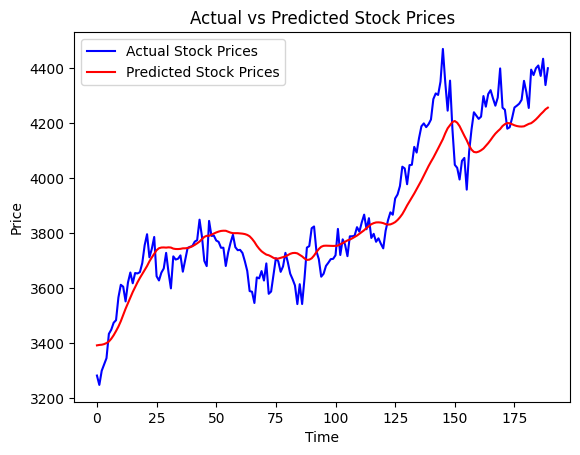

In [15]:
# Plot the predicted vs actual prices
import matplotlib.pyplot as plt

plt.plot(actual_prices, color='blue', label='Actual Stock Prices')
plt.plot(predicted_prices, color='red', label='Predicted Stock Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 11516.702187317605
Mean Absolute Error: 87.68442254317434


In [ ]:
# List to store growth predictions
growth_predictions = []

# Loop through each stock, fetch data, and make predictions
for index, row in stocks_df.iterrows():
    ticker = row['Ticker']
    exchange = row['Exchange']
    full_ticker = get_full_ticker(ticker, exchange)

    print(f"Fetching data for {full_ticker}...")

    # Fetch stock data
    stock_data = fetch_stock_data(full_ticker)

    if stock_data is not None:
        # Preprocess the data and make predictions
        X_train, y_train, scaler = preprocess_data(stock_data)

        # Assuming you've already trained the model, use it to predict the next day's price
        predicted_price = predict_future_prices(trained_model, stock_data, scaler)

        # Get the last available price from the dataset
        last_price = stock_data['Adj Close'].iloc[-1]

        # Calculate predicted growth percentage
        growth_percentage = (predicted_price[0][0] - last_price) / last_price * 100

        # Append the ticker and predicted growth percentage to the list
        growth_predictions.append((ticker, growth_percentage))
    else:
        print(f"Skipping {full_ticker} due to missing data.")


Fetching data for ABEV3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 29ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for B3SA3.SA...
1/1 [==============================] - 0s 27ms/step
Fetching data for BBAS3.SA...



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for BBDC3.SA...
1/1 [==============================] - 0s 28ms/step
Fetching data for BBSE3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 27ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for BPAC11.SA...
1/1 [==============================] - 0s 27ms/step
Fetching data for BRFS3.SA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step
Fetching data for CCRO3.SA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step
Fetching data for CPFE3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for CRFB3.SA...
1/1 [==============================] - 0s 27ms/step
Fetching data for CSAN3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 27ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for CSNA3.SA...
1/1 [==============================] - 0s 29ms/step
Fetching data for EGIE3.SA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step
Fetching data for EMBR3.SA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step
Fetching data for EQTL3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for HYPE3.SA...
1/1 [==============================] - 0s 28ms/step
Fetching data for IRBR3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for JBSS3.SA...
1/1 [==============================] - 0s 27ms/step
Fetching data for KLBN11.SA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
Fetching data for LREN3.SA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
Fetching data for MDIA3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed


Fetching data for MGLU3.SA...
1/1 [==============================] - 0s 30ms/step
Fetching data for MULT3.SA...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for NTCO3.SA...
1/1 [==============================] - 0s 29ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for PETR3.SA...
1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for PSSA3.SA...
1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed


Fetching data for RADL3.SA...
1/1 [==============================] - 0s 29ms/step
Fetching data for RAIL3.SA...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for RENT3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 32ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for SANB11.SA...
1/1 [==============================] - 0s 29ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for SBSP3.SA...
1/1 [==============================] - 0s 27ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for SUZB3.SA...
1/1 [==============================] - 0s 28ms/step
Fetching data for UGPA3.SA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step
Fetching data for VALE3.SA...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 29ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for WEGE3.SA...
1/1 [==============================] - 0s 29ms/step
Fetching data for BIMBOA.MX...


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for GAPB.MX...
1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for 532810.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532810.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


No data found for 532810.BO
Skipping 532810.BO due to missing data.
Fetching data for 532848.BO...
1/1 [==============================] - 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Fetching data for 500043.BO...
1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for 500087.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500087.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500087.BO
Skipping 500087.BO due to missing data.
Fetching data for 500103.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500103.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


No data found for 500103.BO
Skipping 500103.BO due to missing data.
Fetching data for 500112.BO...
1/1 [==============================] - 0s 28ms/step
Fetching data for 500114.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500114.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500114.BO
Skipping 500114.BO due to missing data.
Fetching data for 500124.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500124.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500124.BO
Skipping 500124.BO due to missing data.
Fetching data for 500180.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500180.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


No data found for 500180.BO
Skipping 500180.BO due to missing data.
Fetching data for 500182.BO...
1/1 [==============================] - 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Fetching data for 500209.BO...
1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for 500247.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500247.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500247.BO
Skipping 500247.BO due to missing data.
Fetching data for 500271.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500271.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


No data found for 500271.BO
Skipping 500271.BO due to missing data.
Fetching data for 500295.BO...
1/1 [==============================] - 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Fetching data for 500302.BO...
1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for 500304.BO...
1/1 [==============================] - 0s 27ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for 500312.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500312.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

No data found for 500312.BO
Skipping 500312.BO due to missing data.
Fetching data for 500325.BO...
1/1 [==============================] - 0s 30ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for 500400.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500400.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500400.BO
Skipping 500400.BO due to missing data.
Fetching data for 500440.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500440.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


No data found for 500440.BO
Skipping 500440.BO due to missing data.
Fetching data for 500470.BO...
1/1 [==============================] - 0s 29ms/step


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for 500510.BO...
1/1 [==============================] - 0s 29ms/step
Fetching data for 500520.BO...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step
Fetching data for 500530.BO...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
Fetching data for 500570.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500570.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

No data found for 500570.BO
Skipping 500570.BO due to missing data.
Fetching data for 500696.BO...
1/1 [==============================] - 0s 29ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Fetching data for 500790.BO...
1/1 [==============================] - 0s 28ms/step



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Fetching data for 500820.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500820.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500820.BO
Skipping 500820.BO due to missing data.
Fetching data for 500875.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['500875.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 500875.BO
Skipping 500875.BO due to missing data.
Fetching data for 507685.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['507685.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 507685.BO
Skipping 507685.BO due to missing data.
Fetching data for 509480.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['509480.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 509480.BO
Skipping 509480.BO due to missing data.
Fetching data for 517300.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['517300.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 517300.BO
Skipping 517300.BO due to missing data.
Fetching data for 524715.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['524715.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 524715.BO
Skipping 524715.BO due to missing data.
Fetching data for 532155.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532155.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532155.BO
Skipping 532155.BO due to missing data.
Fetching data for 532174.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532174.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532174.BO
Skipping 532174.BO due to missing data.
Fetching data for 532215.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532215.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532215.BO
Skipping 532215.BO due to missing data.
Fetching data for 532281.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532281.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532281.BO
Skipping 532281.BO due to missing data.
Fetching data for 532424.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532424.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532424.BO
Skipping 532424.BO due to missing data.
Fetching data for 532454.BO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['532454.BO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


No data found for 532454.BO
Skipping 532454.BO due to missing data.
Fetching data for 532482.BO...


[*********************100%***********************]  1 of 1 completed

In [20]:
# Sort stocks by predicted growth percentage in descending order
growth_predictions_sorted = sorted(growth_predictions, key=lambda x: x[1], reverse=True)

# Get the top 10 stocks
top_10_stocks = growth_predictions_sorted[:10]

# Print the top 10 stocks and their predicted growth
print("Top 10 Stocks Predicted to Grow the Most:")
for stock, growth in top_10_stocks:
    print(f"Ticker: {stock}, Predicted Growth: {growth:.2f}%")


Top 10 Stocks Predicted to Grow the Most:
Ticker: BNED, Predicted Growth: 320.40%
Ticker: SAVE, Predicted Growth: 80.48%
Ticker: TCS, Predicted Growth: 59.43%
Ticker: SEDG, Predicted Growth: 54.23%
Ticker: CHNR, Predicted Growth: 39.41%
Ticker: RTC, Predicted Growth: 39.39%
Ticker: AEHR, Predicted Growth: 31.83%
Ticker: CHPT, Predicted Growth: 31.75%
Ticker: LAC, Predicted Growth: 31.08%
Ticker: SFIX, Predicted Growth: 27.99%
